In [154]:
import sys
sys.path.insert(0, '../gambit')

import os
import numpy as np
from scipy import stats
from scipy import ndimage

from gambit import create_diff_image, clean_data, create_diff_per_image
from mask import create_segmentation_masks,create_ellipse_mask_from_sep_object
from fits import read_fits, view_fits, write_fits, view_fits_with_sep_objects

In [155]:
bands_in_order = ['g','r','i','z','y']

In [156]:
path_to_input = "/Users/cora-at-work/Desktop/github/spin-parity-catalog/original/galaxies/"
table_key = "table2"

def get_galaxy_list():
    return os.listdir(os.path.join(path_to_input,table_key))

def fits_path(name,band):
    return os.path.join(path_to_input,table_key,name,"{}_{}.fits".format(name,band))

In [157]:
import sep
from scipy import ndimage
import matplotlib.pyplot as plt

def calculate_center_of_mass(the_mask):
    #Important note: returns (y,x) not (x,y)
    return ndimage.center_of_mass(the_mask)

def calc_dist(cm_x,cm_y,el_x,el_y):
    return (((cm_x-el_x)*(cm_x-el_x)) + ((cm_y-el_y)*(cm_y-el_y)))**0.5

def calc_sep_size(a,b):
    return 3.14*a*b

def run_sep(data, cm_x, cm_y):
    #print(np.min(data),np.max(data),np.sum(np.isinf(data)),np.sum(np.isnan(data)))
    data = data.byteswap().newbyteorder()
    bkg = sep.Background(data)
    data_sub = data - bkg
    
    objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
    #view_fits_with_sep_objects(data,objects,2)
    
    the_el_sep = None
    the_el_sep_dist = np.inf
    
    #return
    
    for i in objects:
        #print(i['a'],i['b'],i['x'],i['y'])
        if calc_sep_size(i['a'],i['b']) < 0.001*data.shape[0]*data.shape[1]: continue
        
        d = calc_dist(cm_x,cm_y,i['x'],i['y'])
        if d < the_el_sep_dist:
            the_el_sep = i; the_el_sep_dist = d
            
    if the_el_sep != None:
        the_el = create_ellipse_mask_from_sep_object(the_el_sep,data.shape,r=2)
        #view_fits(the_el)
        return the_el
    return None

In [158]:
def get_cms(diff_per,foreground):
    thresholds = []
    above_threshold_cm = []
    below_threshold_cm = []
    
    m, s = np.mean(diff_per[foreground]), np.std(diff_per[foreground])
    
    for i in np.linspace(m-1*s,m+1*s):
        above_area = np.logical_and(foreground,diff_per>=i)
        below_area = np.logical_and(foreground,diff_per<i)
        
        thresholds.append(i)
        above_threshold_cm.append(calculate_center_of_mass(above_area))
        below_threshold_cm.append(calculate_center_of_mass(below_area))
        
    return (thresholds,above_threshold_cm,below_threshold_cm)

def visualize_diff_cm(diff,foreground):
    (ts,a_cms,b_cms) = get_cms(diff,foreground)
    
    a_points = np.asarray(a_cms)
    b_points = np.asarray(b_cms)

    c = calculate_center_of_mass(foreground)
    plt.figure(figsize=(20,10))
    plt.imshow(diff, interpolation='nearest', cmap='gray', origin='lower')
    plt.plot(a_points[:,1],a_points[:,0],color="blue") #break down above x,and y 
    plt.plot(b_points[:,1],b_points[:,0],color="red") #break down below x,and y
    plt.plot((a_points[:,1]+b_points[:,1])/2,(a_points[:,0]+b_points[:,0])/2,color="orange") #break down above x,and y 
    plt.plot(c[1],c[0],marker='v',color='green')

    plt.show()

In [159]:
def diff_sep(name,first_band,base_band):
    first_band_path = fits_path(name,first_band)
    base_band_path = fits_path(name,base_band)
    
    if not (os.path.exists(first_band_path) and os.path.exists(base_band_path)): 
        print("path does not exist gaurd")
        return None

    first_band_data = clean_data(read_fits(first_band_path)) #added clean to handle infs/ nans
    base_band_data = clean_data(read_fits(base_band_path)) #added clean to handle infs/ nans
    
    if first_band_data.shape != base_band_data.shape: 
        print("shape issue gaurd")
        return None
    
    (foreground,_) = create_segmentation_masks(base_band_data)
    cm_y, cm_x = calculate_center_of_mass(foreground)

    the_el = run_sep(base_band_data, cm_x, cm_y)
    if the_el is None:
        print("issue with sep guard")
        return None
    the_diff = create_diff_image(first_band_data,base_band_data,the_el)
    #the_diff = create_diff_per_image(first_band_data,base_band_data,the_el)
    #view_fits(the_diff)
    visualize_diff_cm(the_diff,the_el)

NGC3627


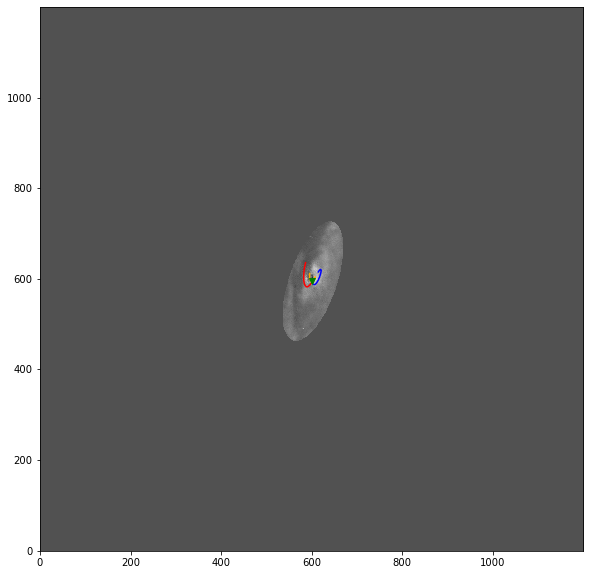

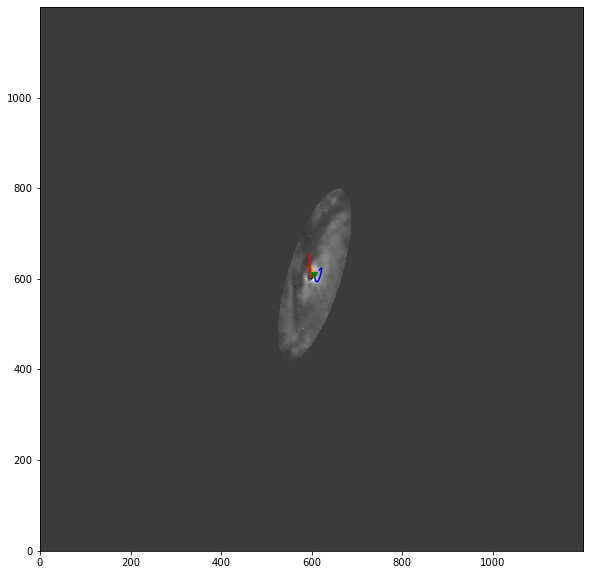

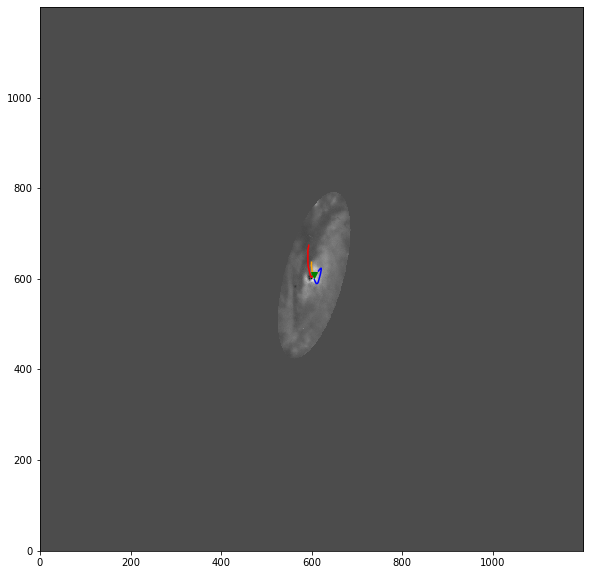

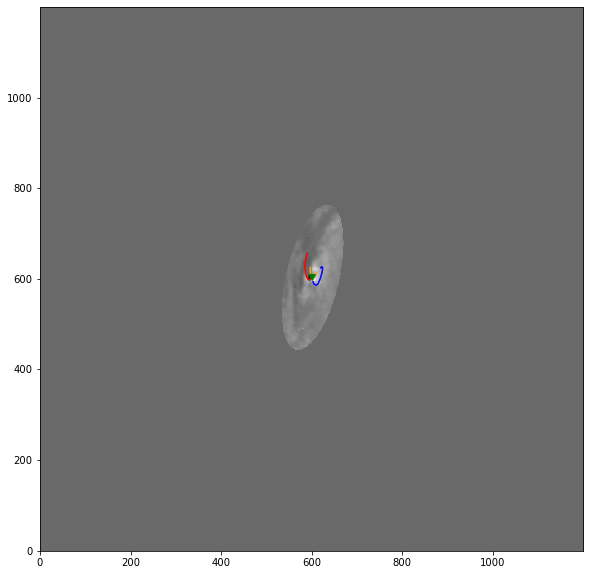

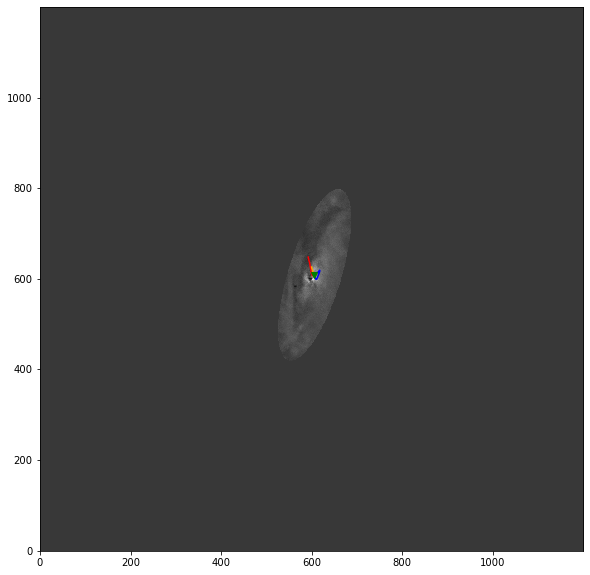

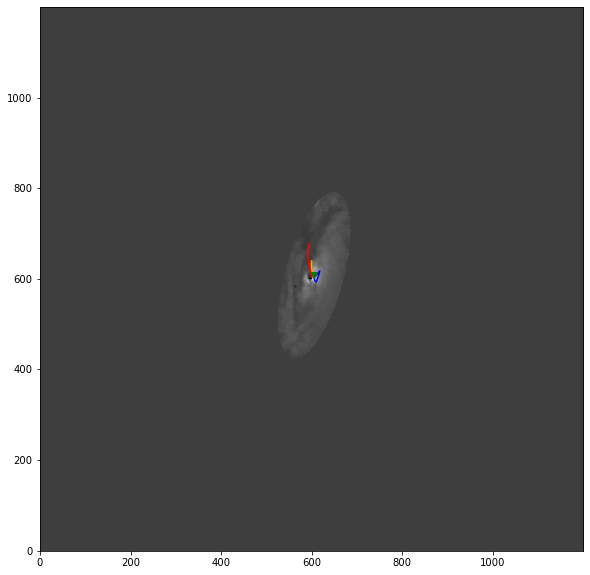

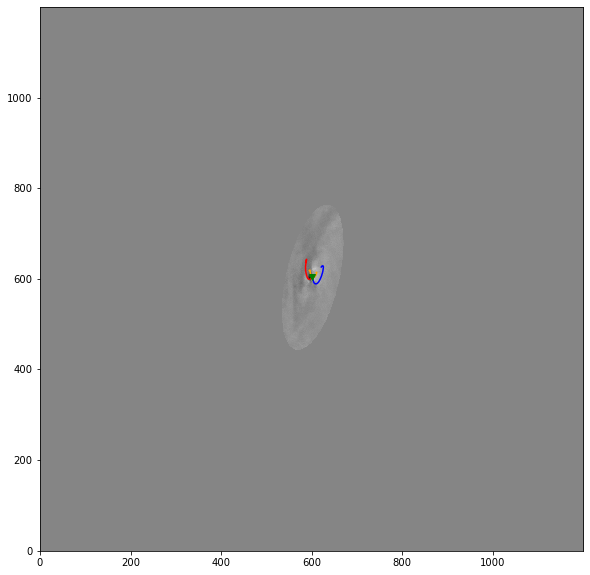

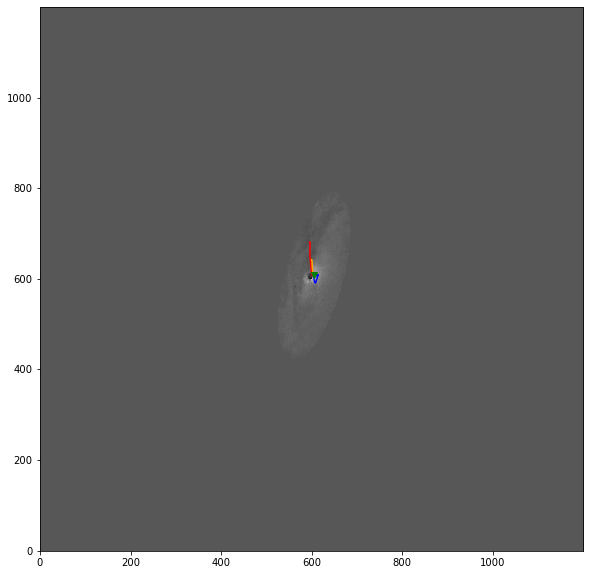

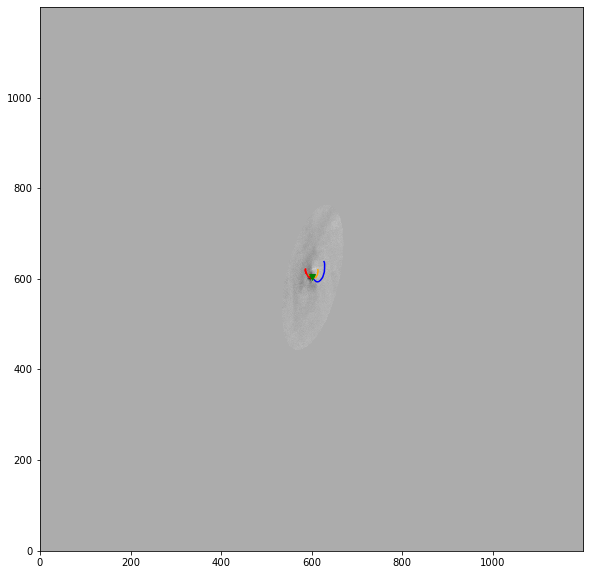

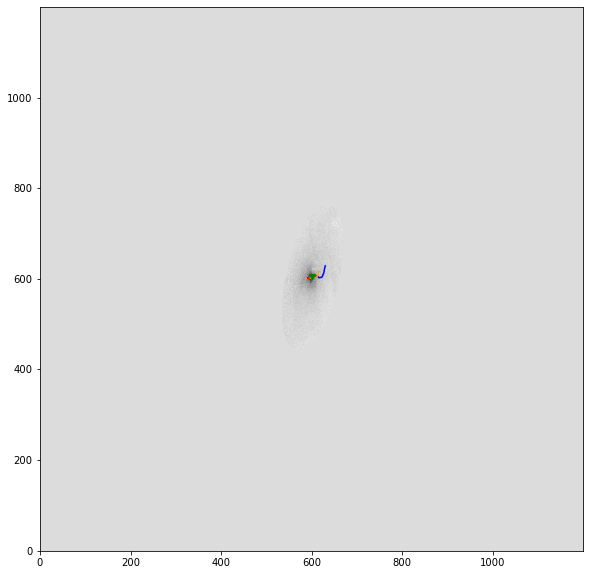

NGC6503


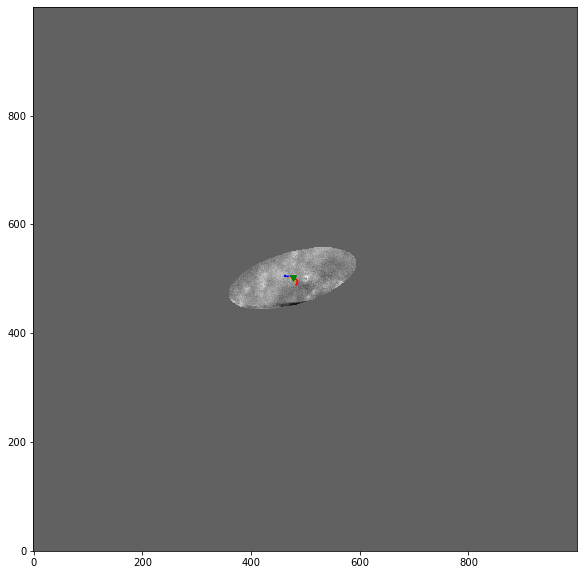

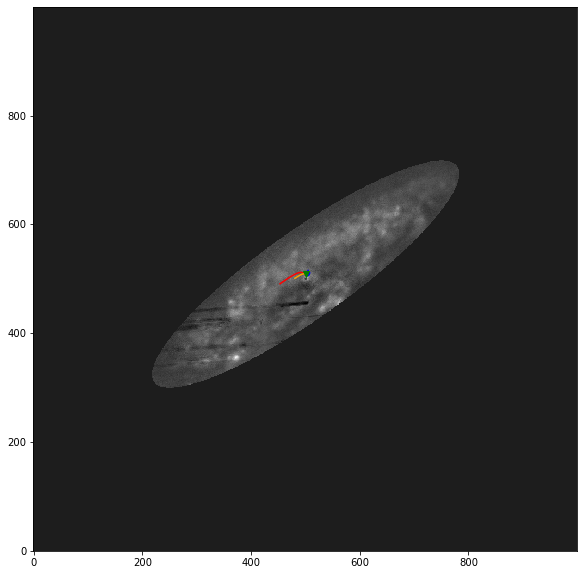

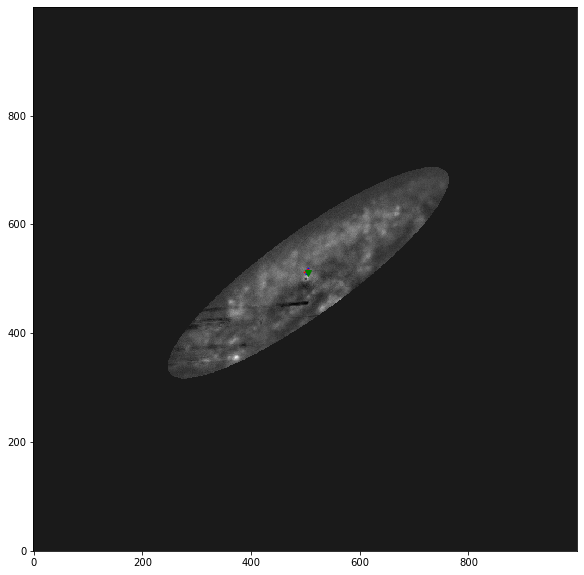

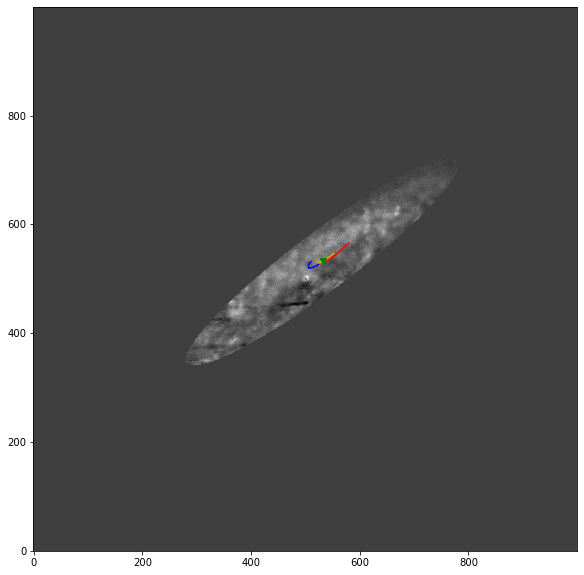

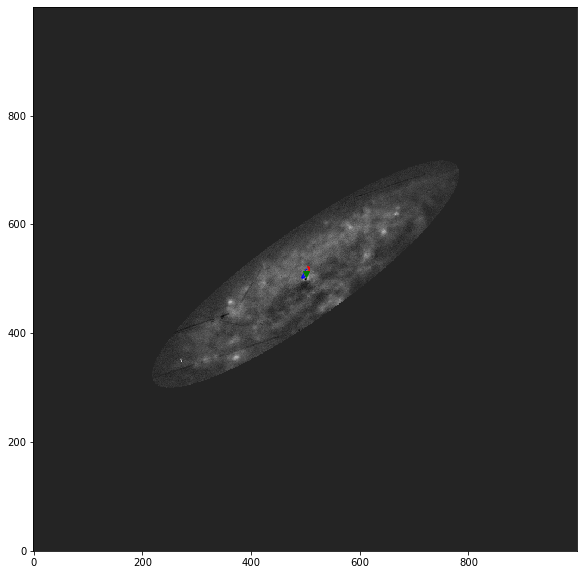

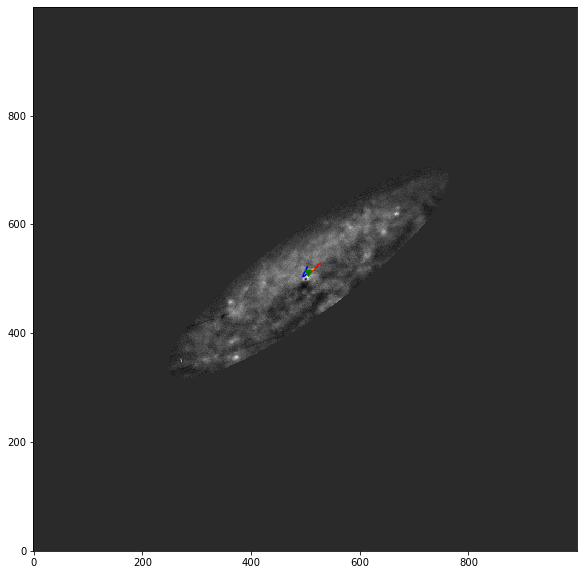

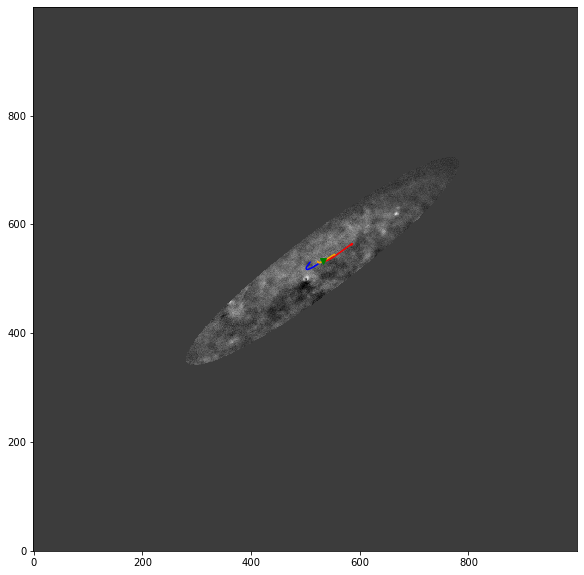

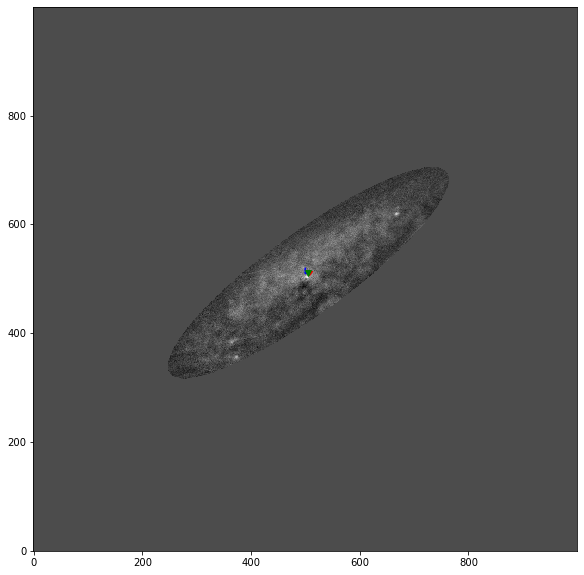

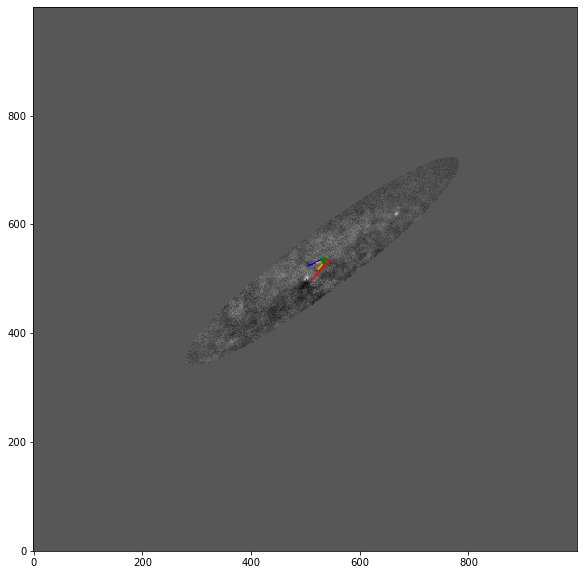

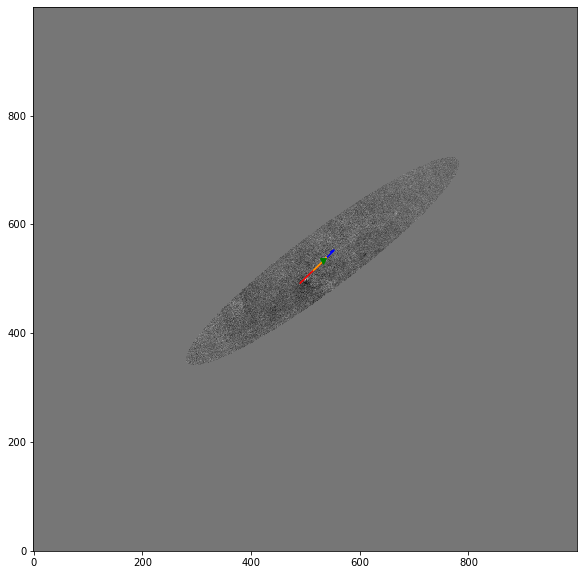

NGC4451


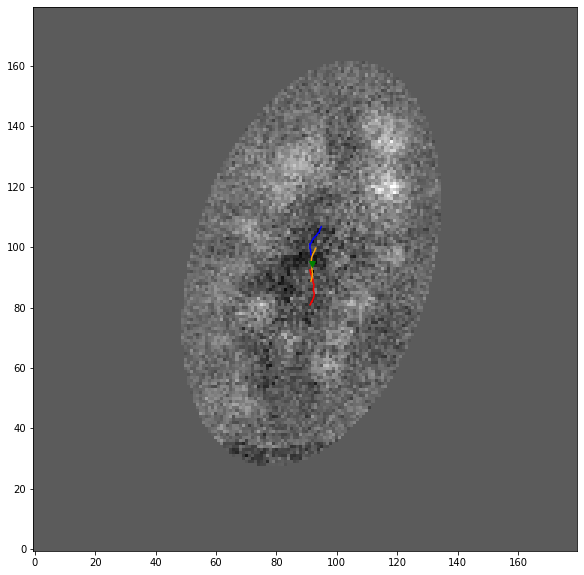

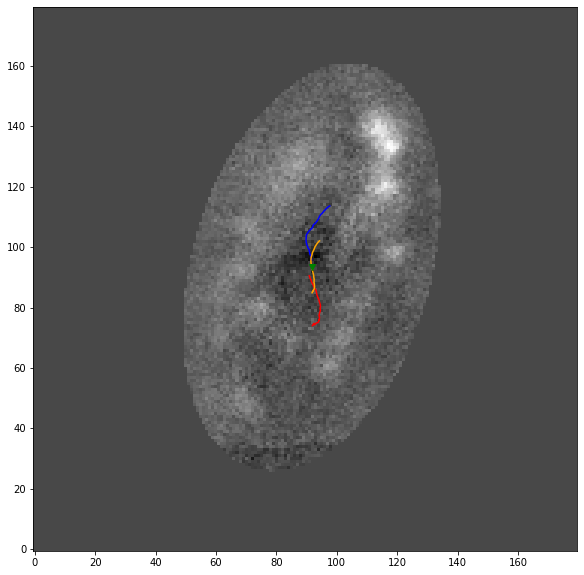

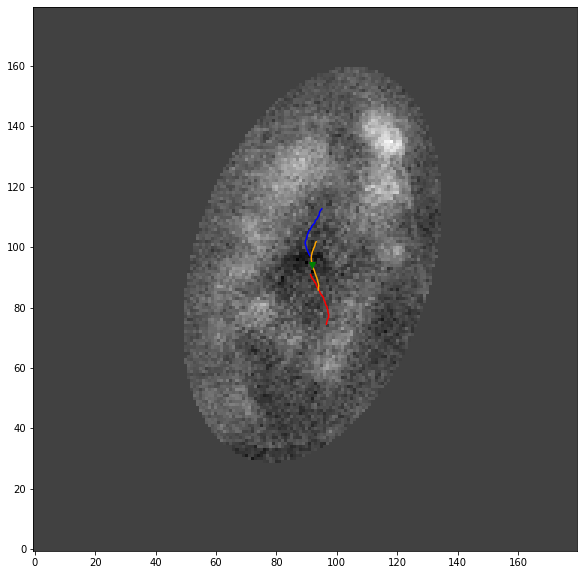

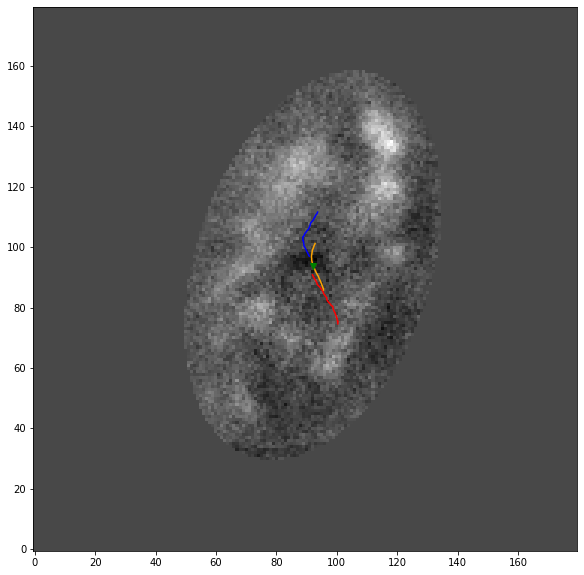

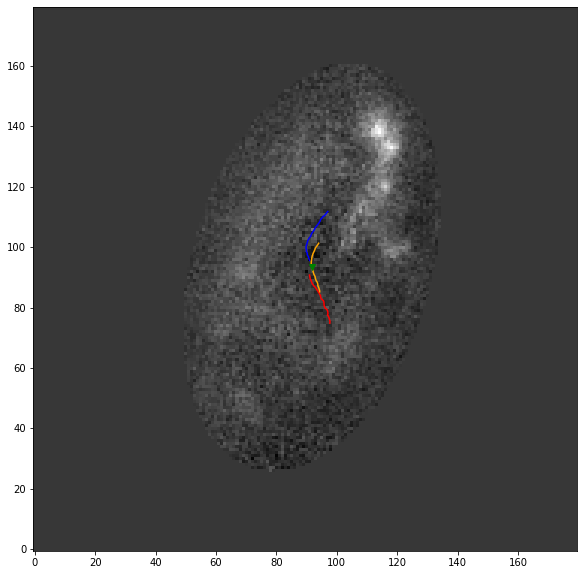

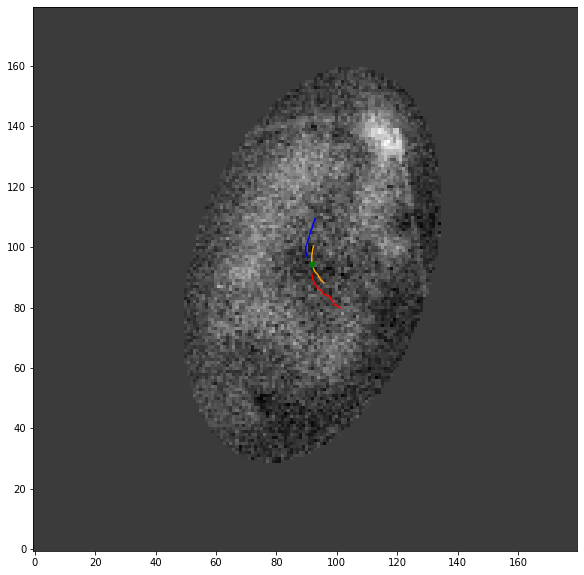

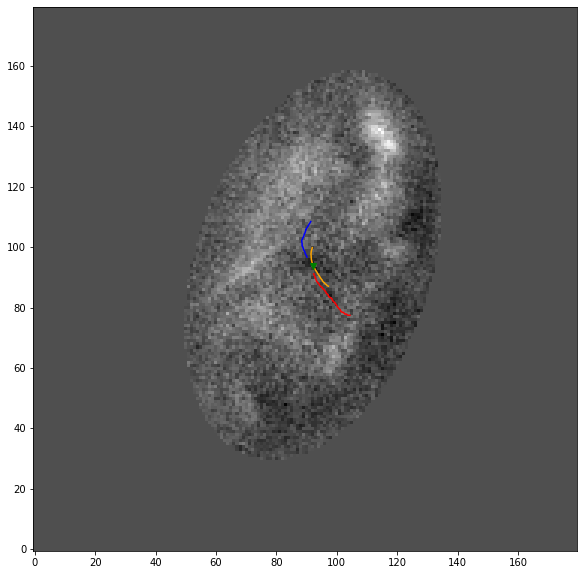

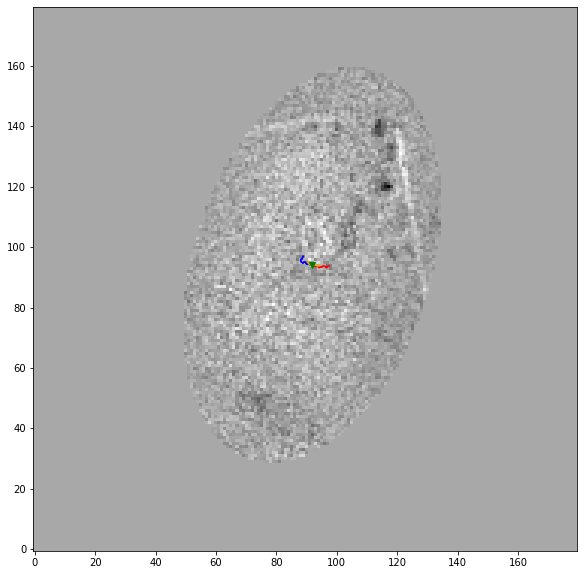

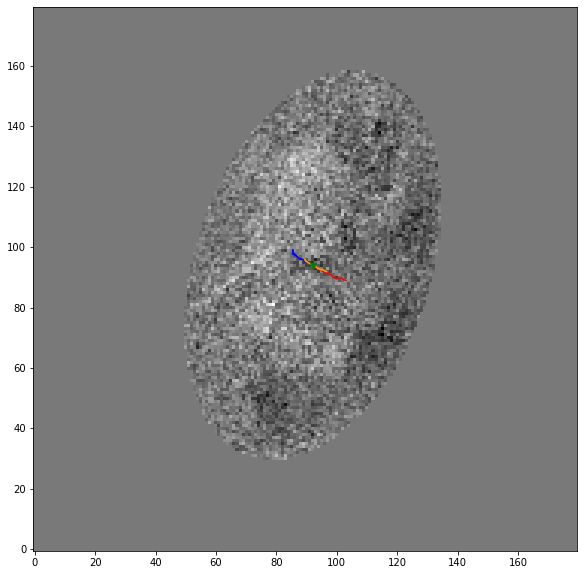

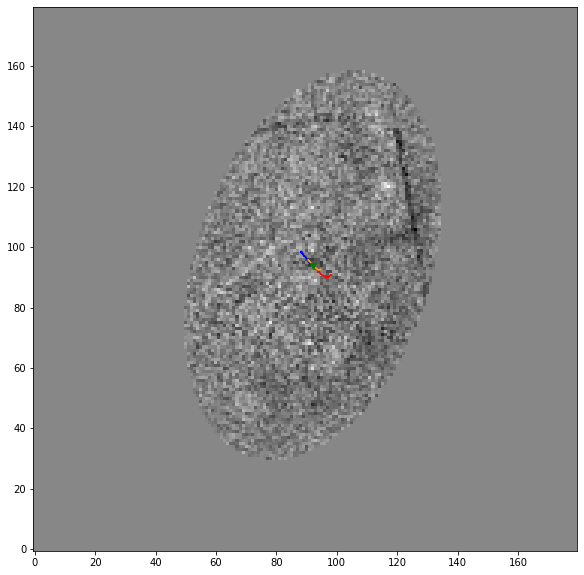

MCG-02-51-004


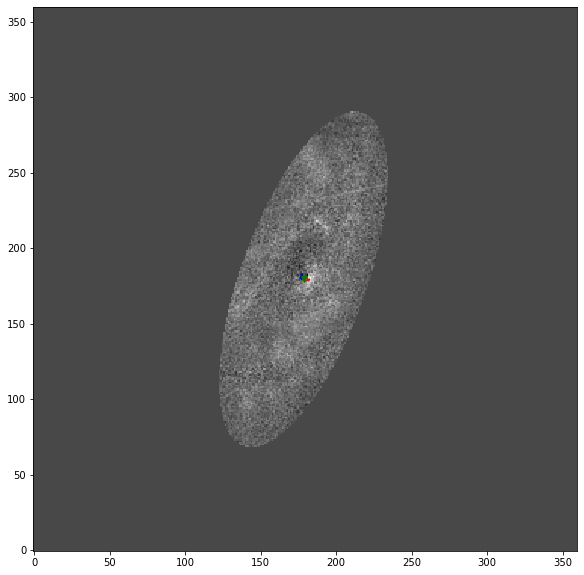

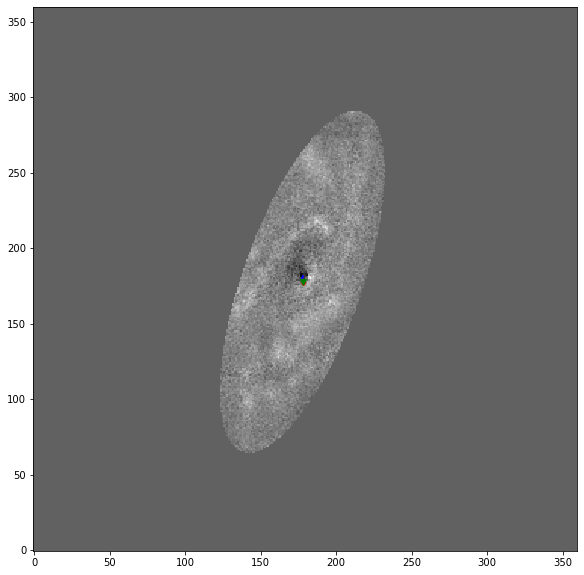

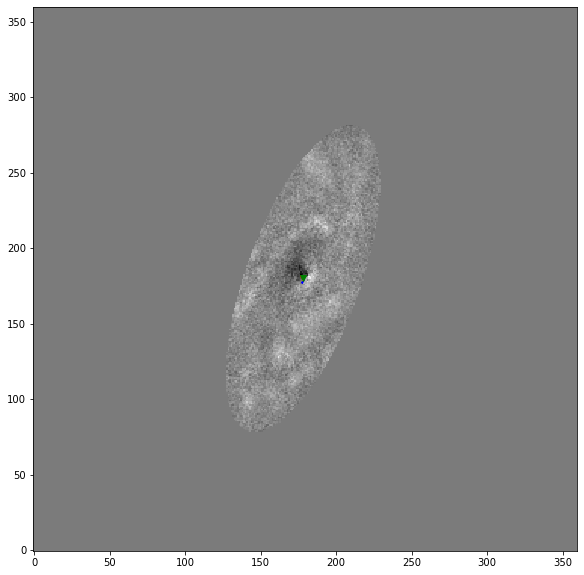

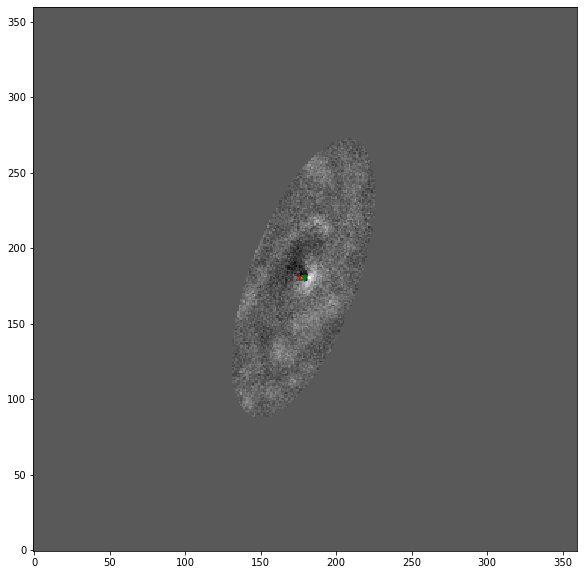

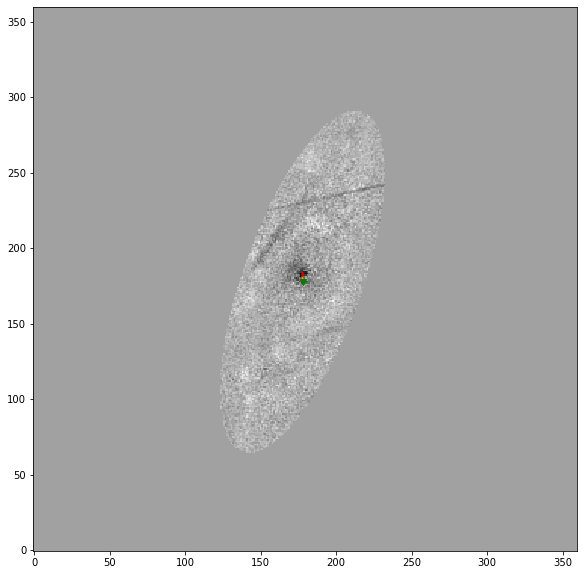

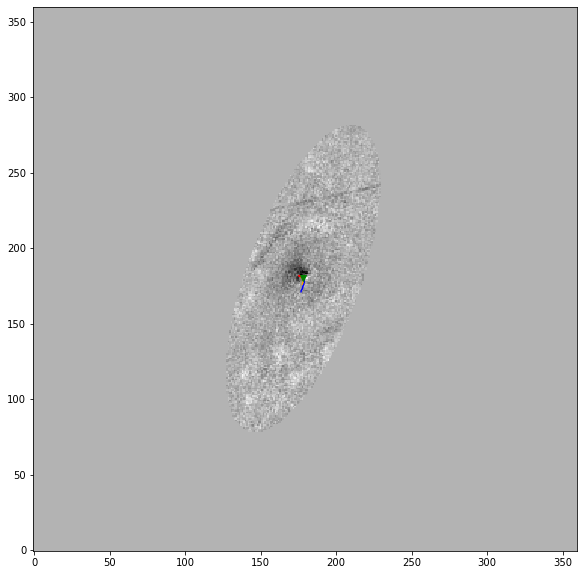

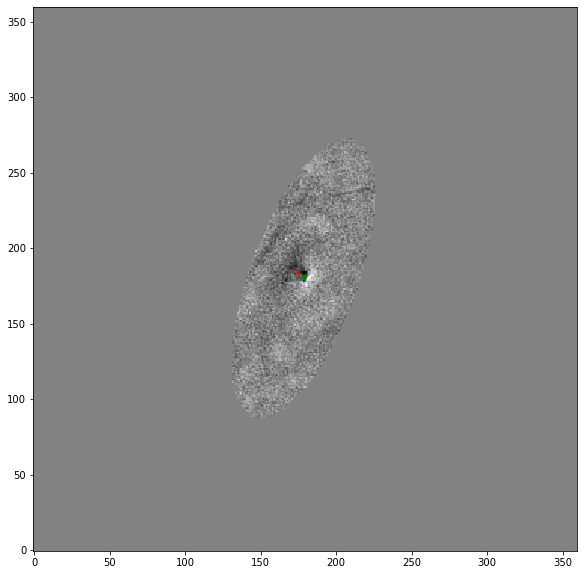

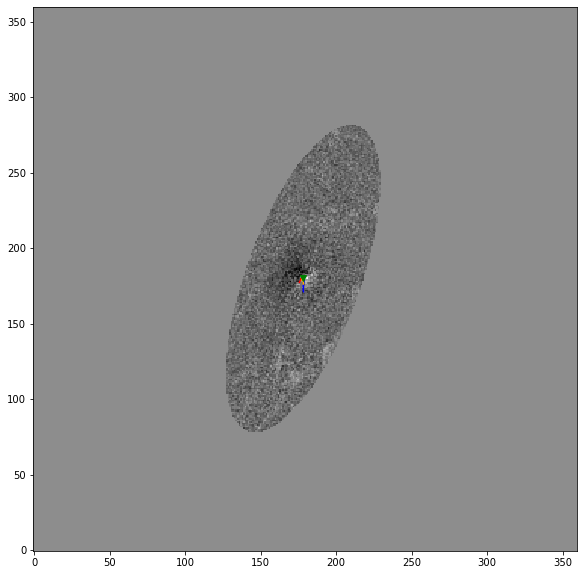

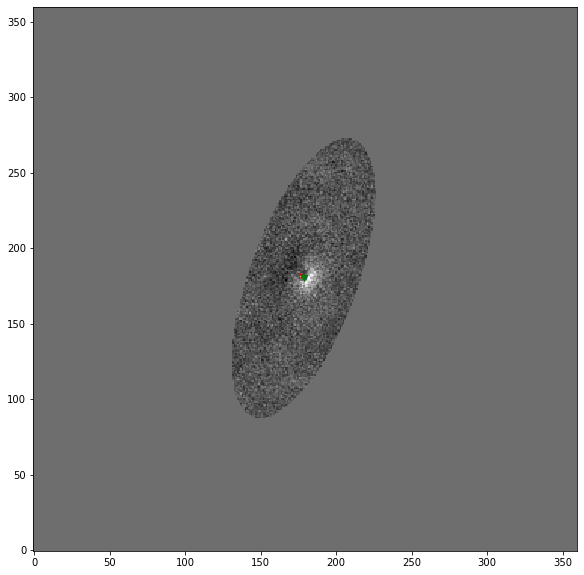

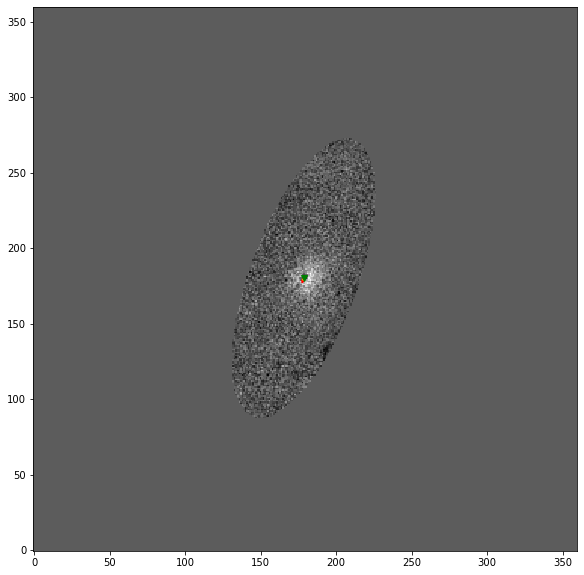

NGC5980


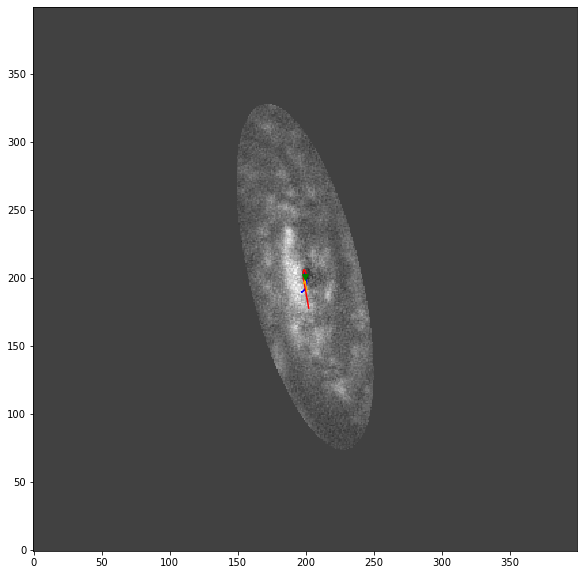

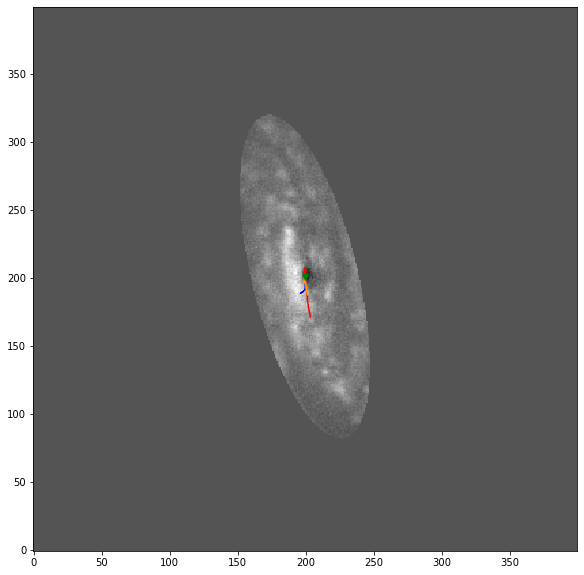

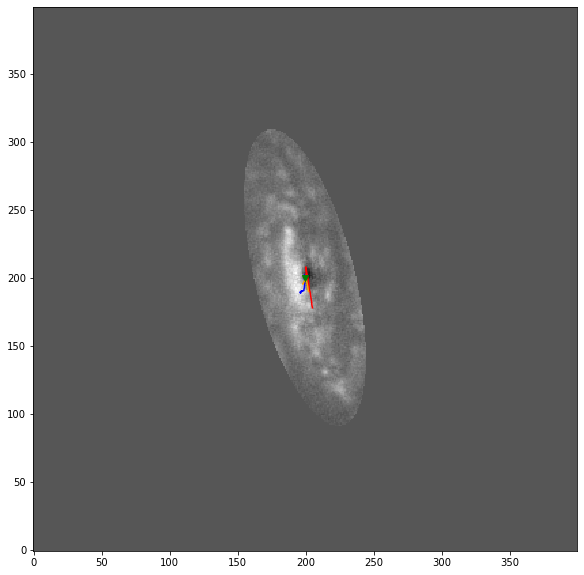

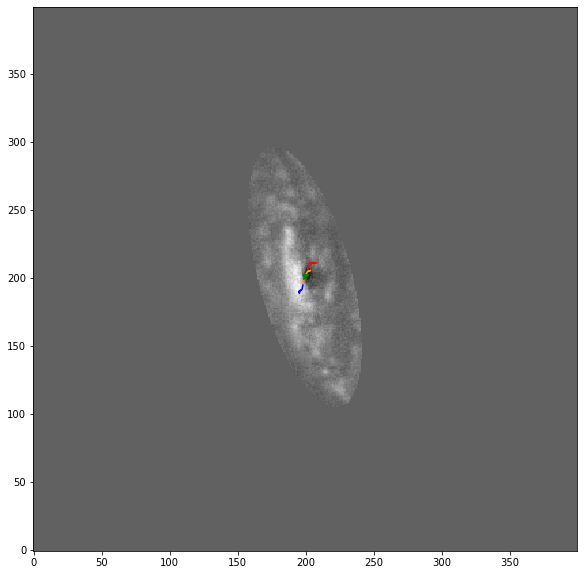

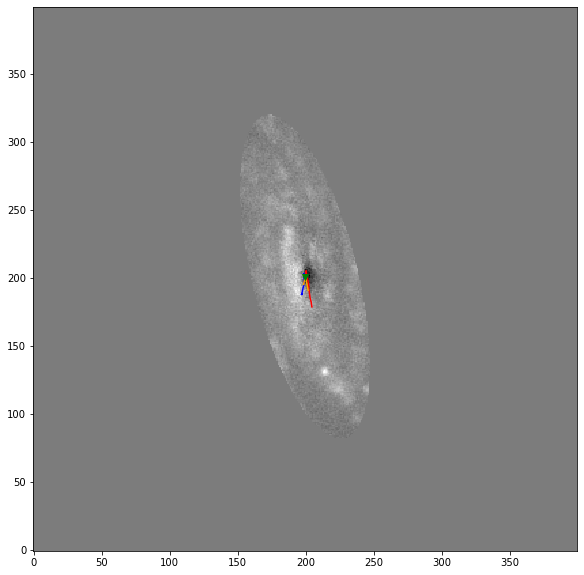

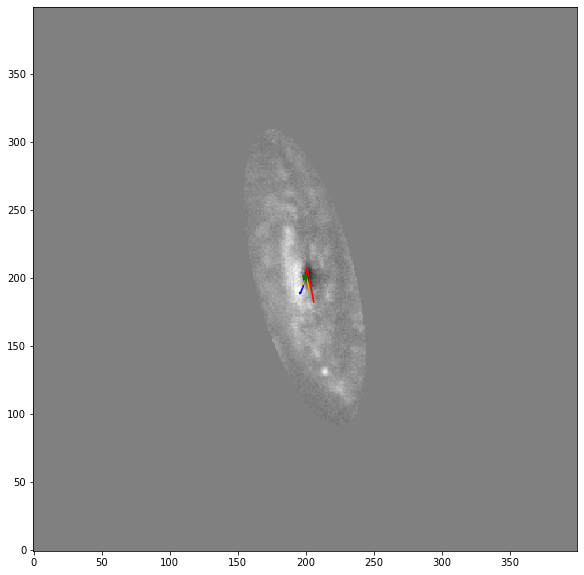

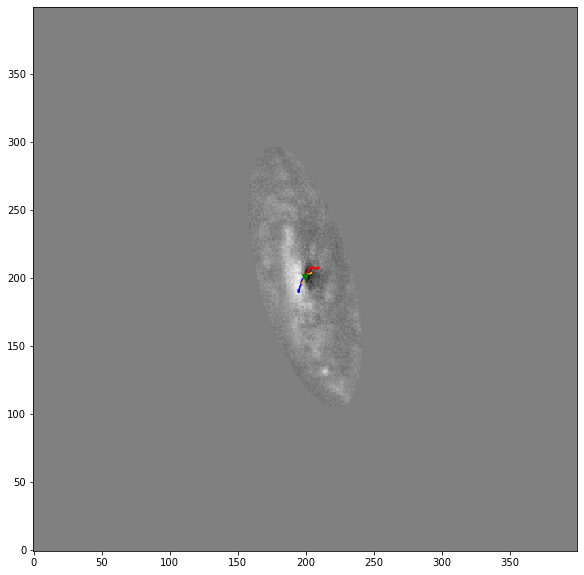

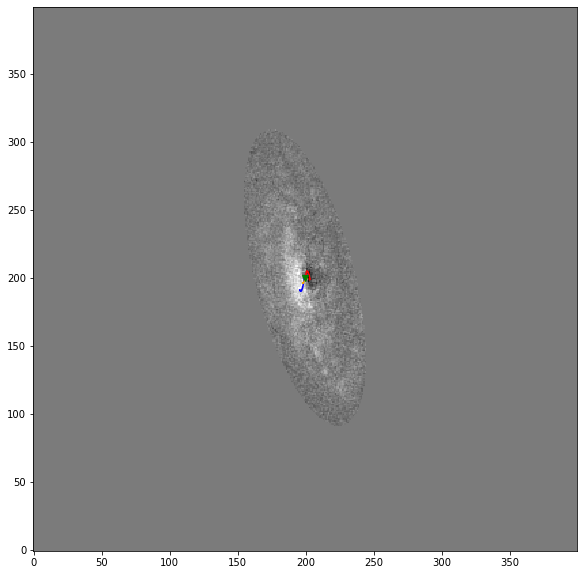

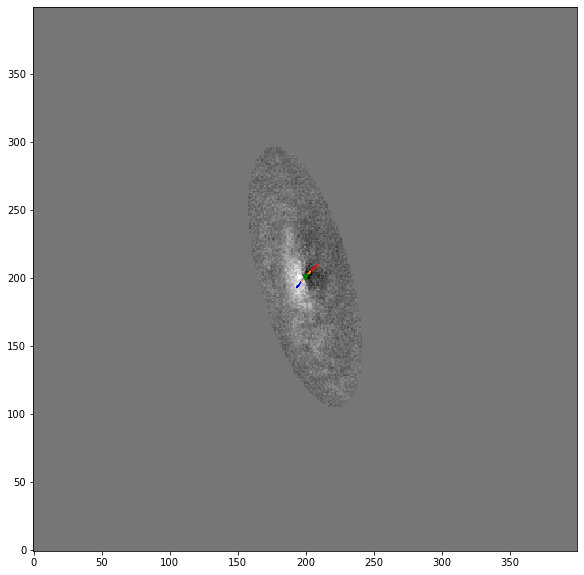

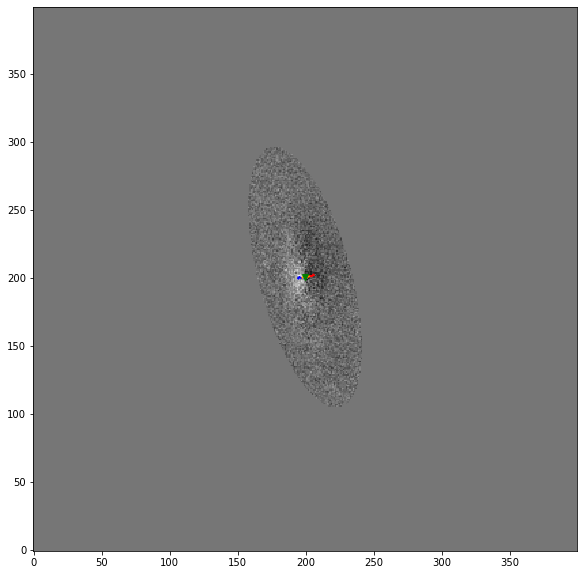

NGC3672


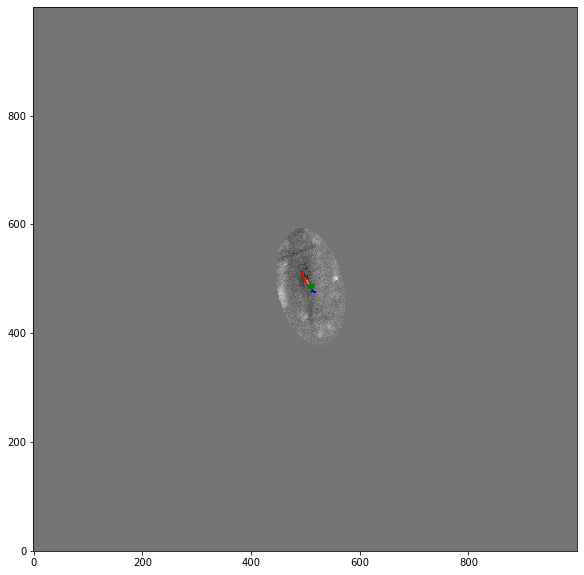

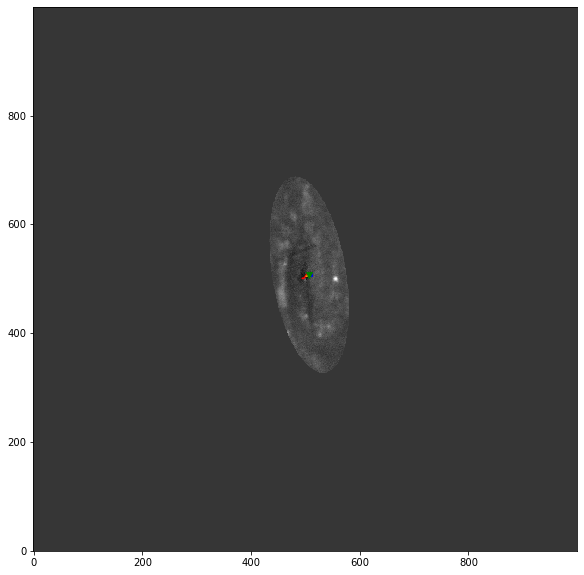

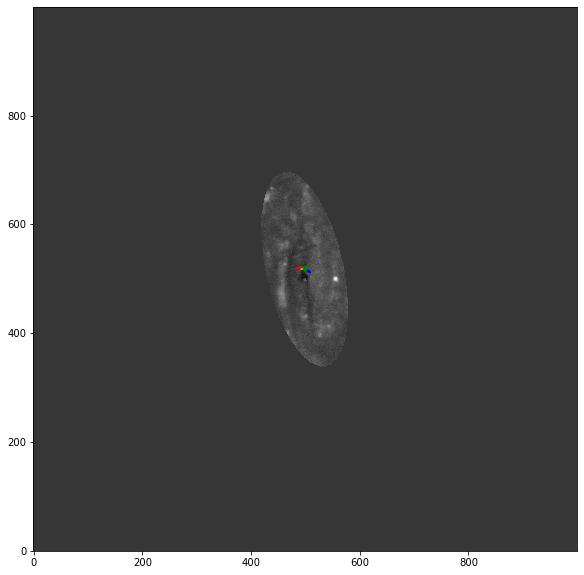

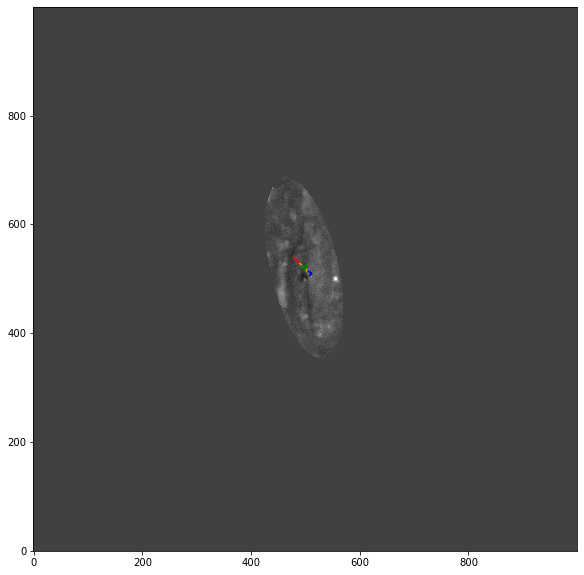

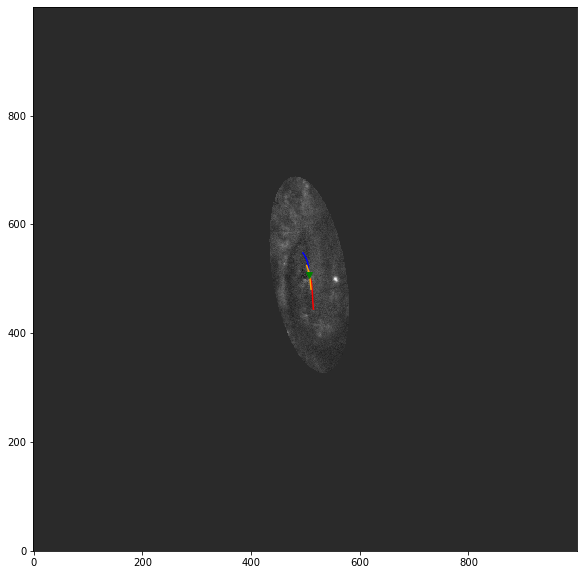

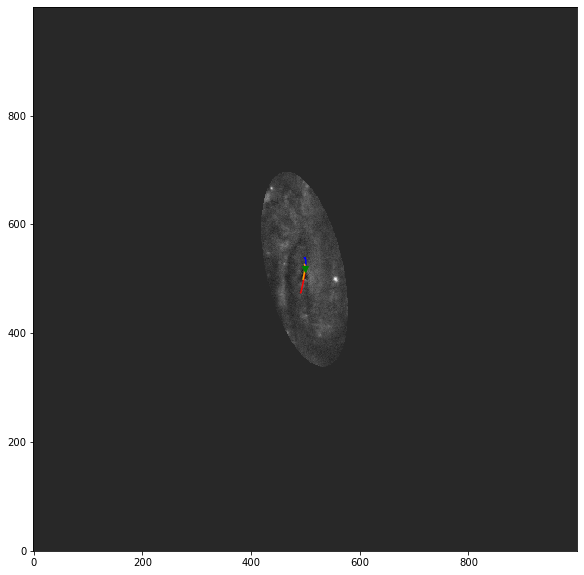

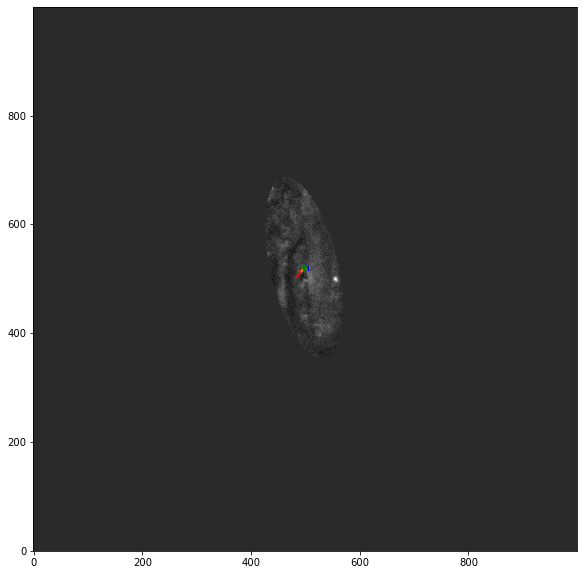

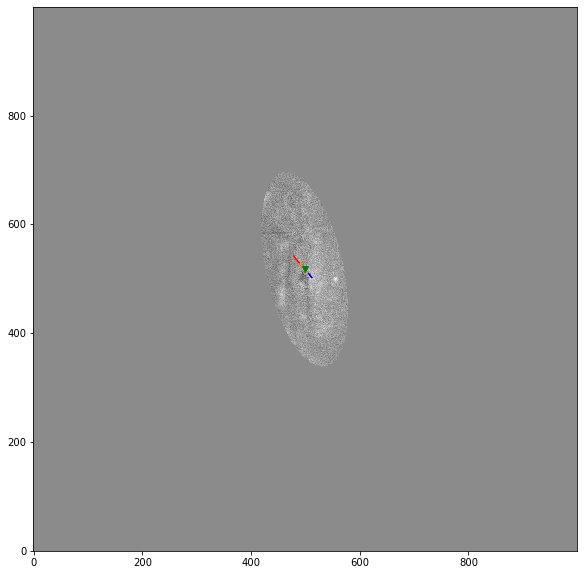

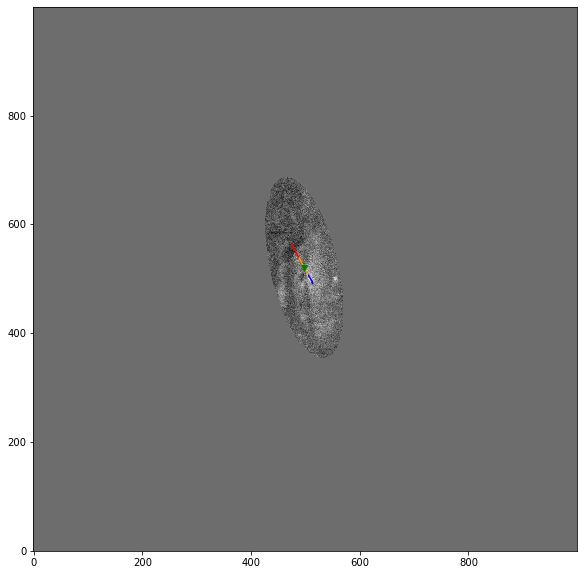

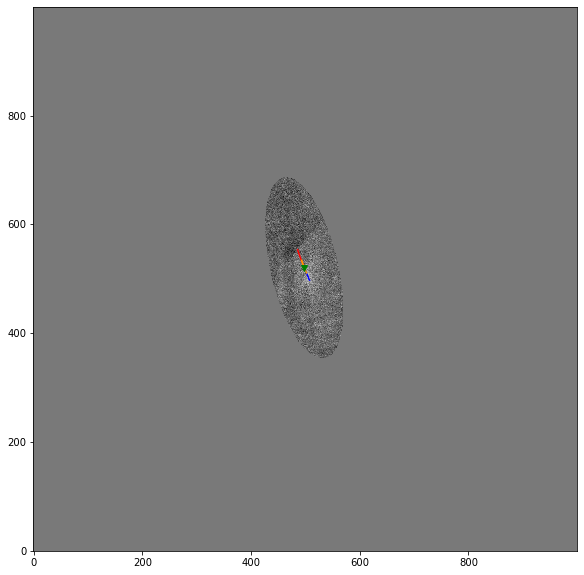

NGC6132


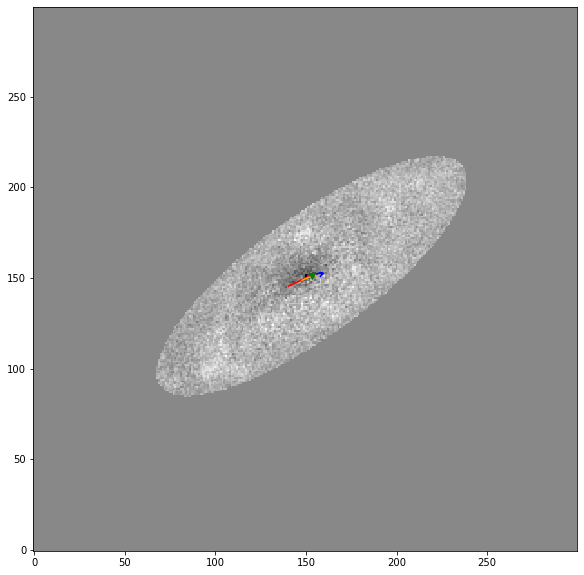

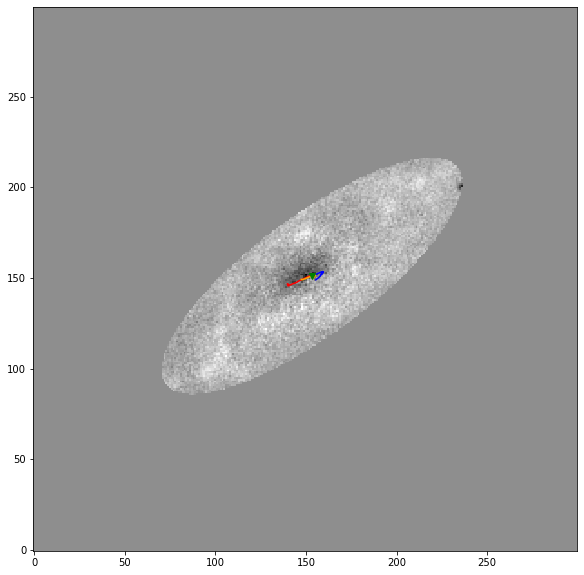

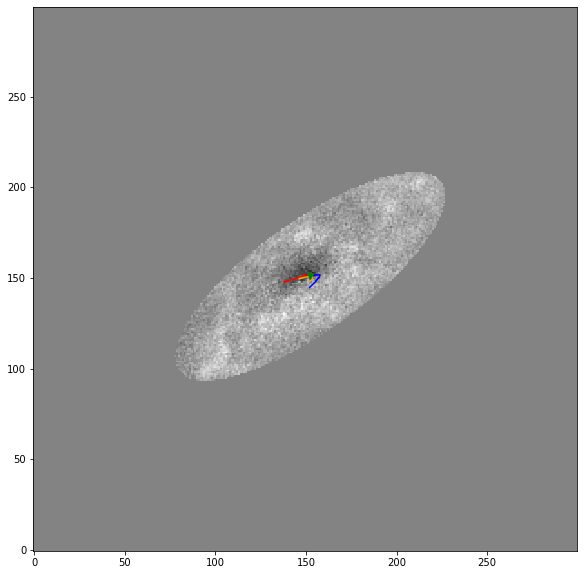

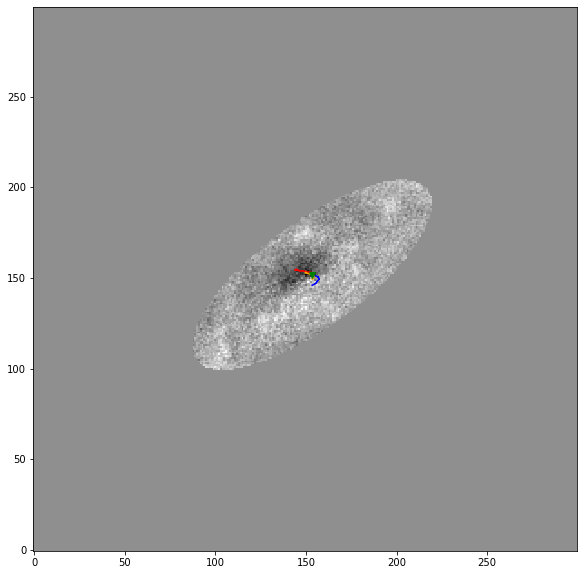

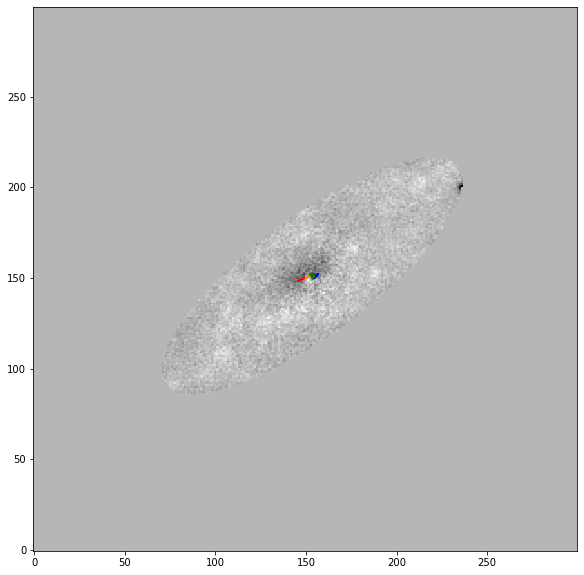

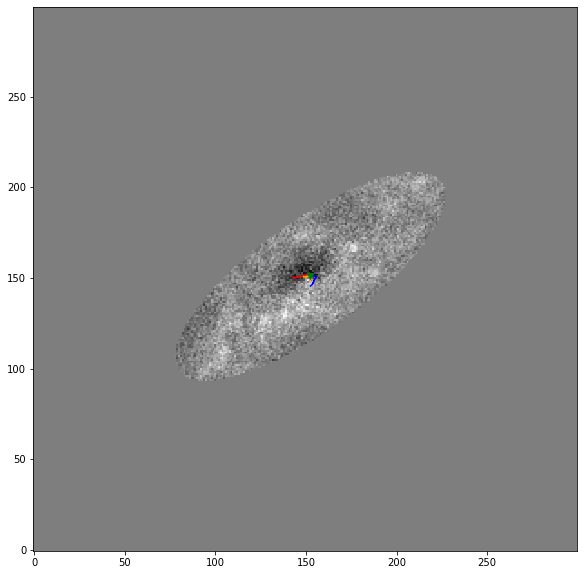

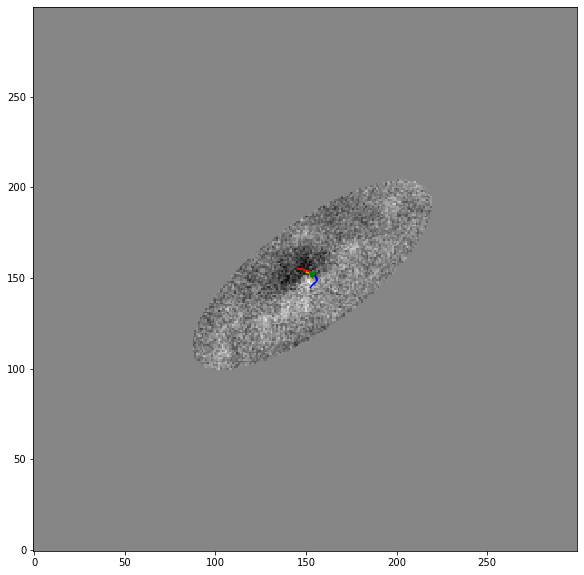

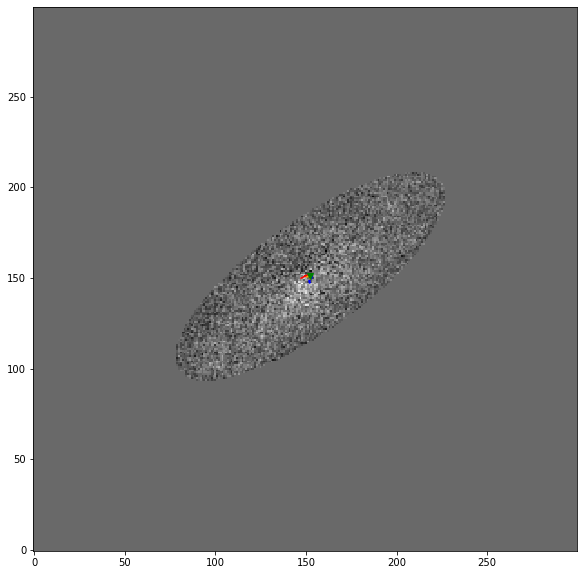

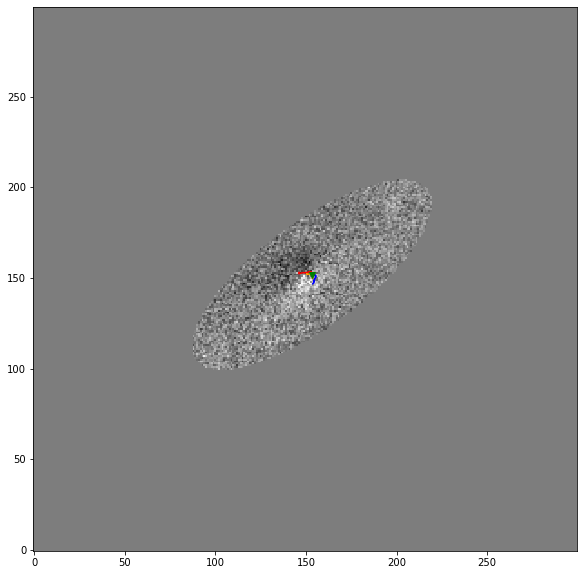

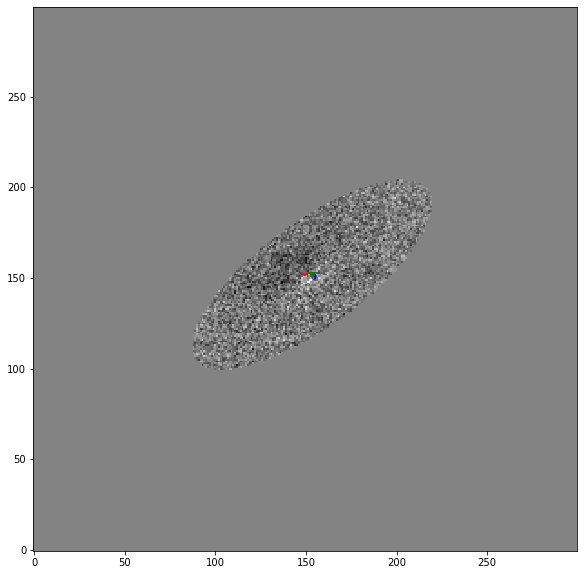

NGC4450


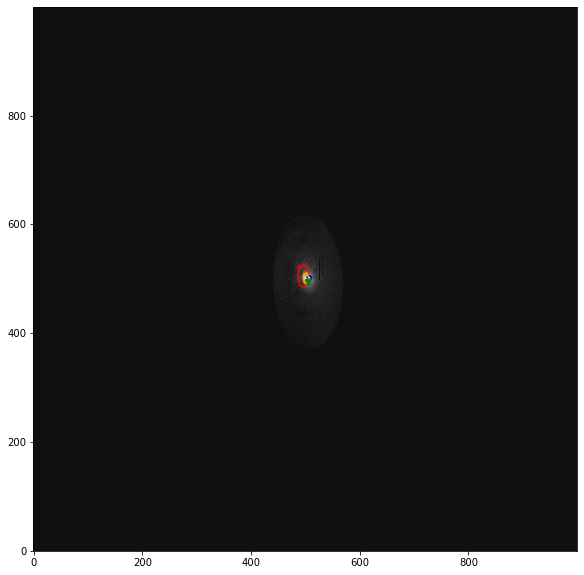

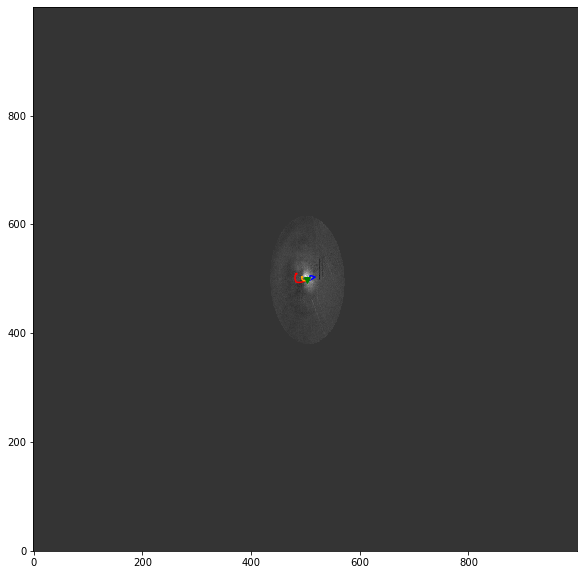

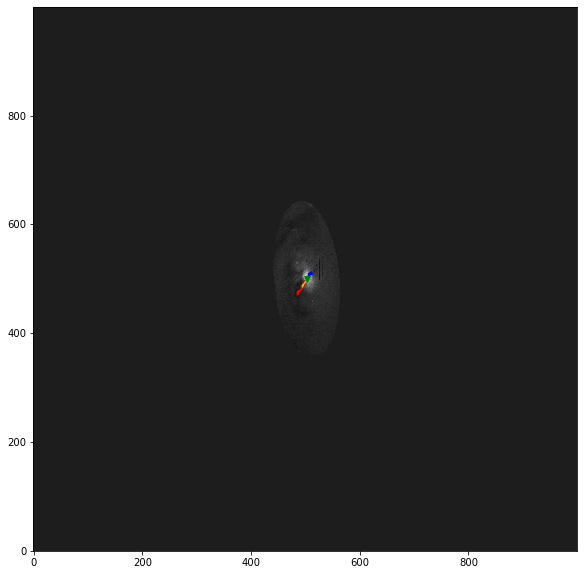

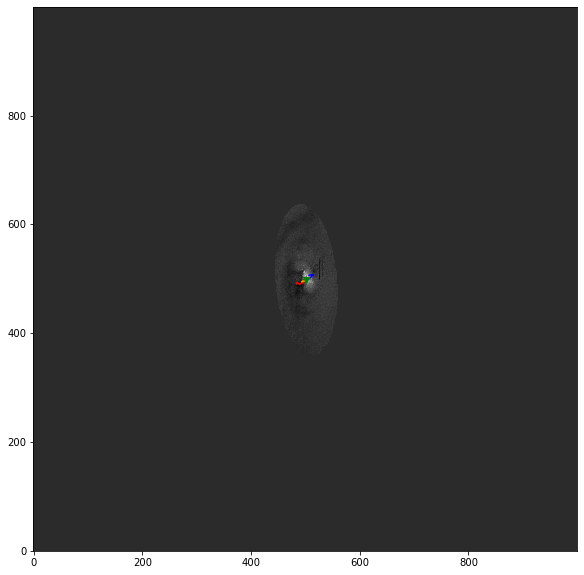

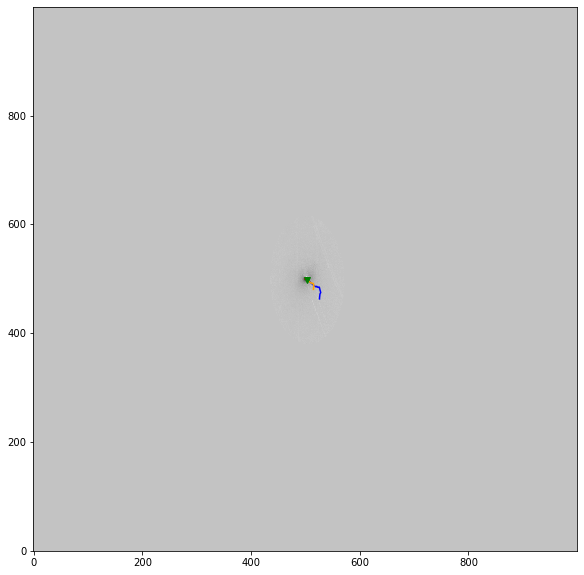

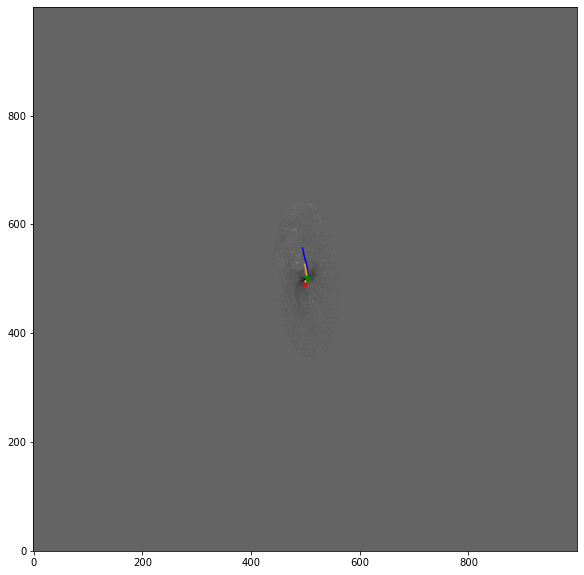

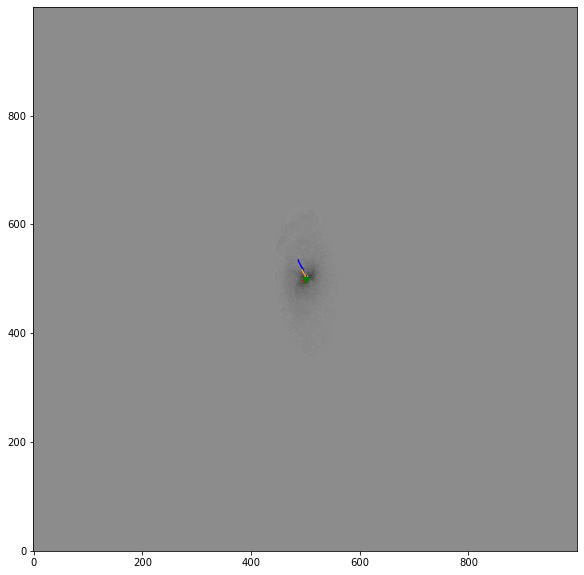

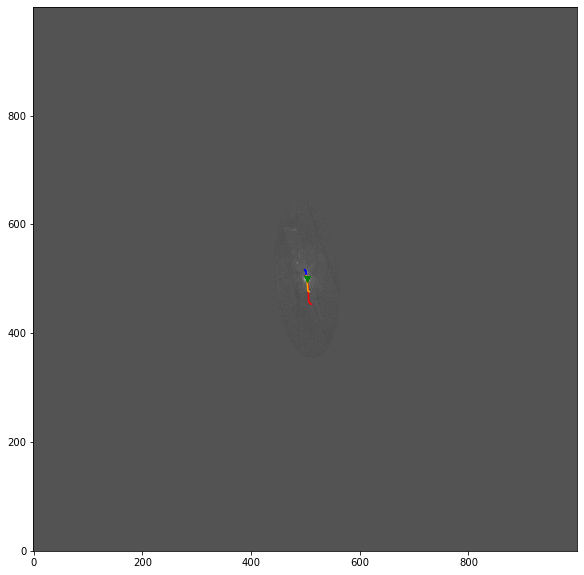

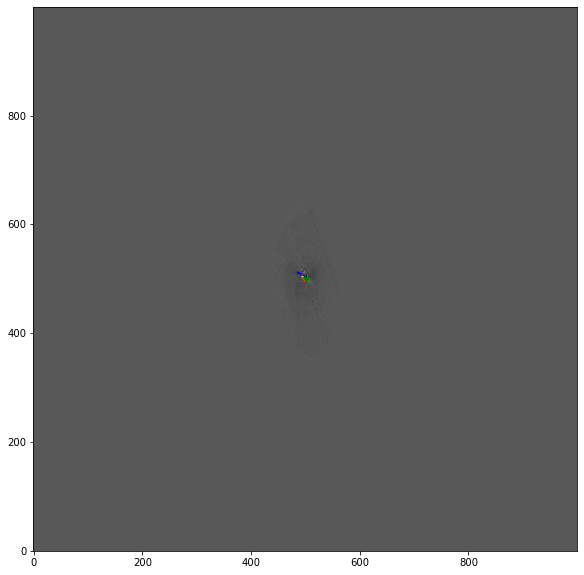

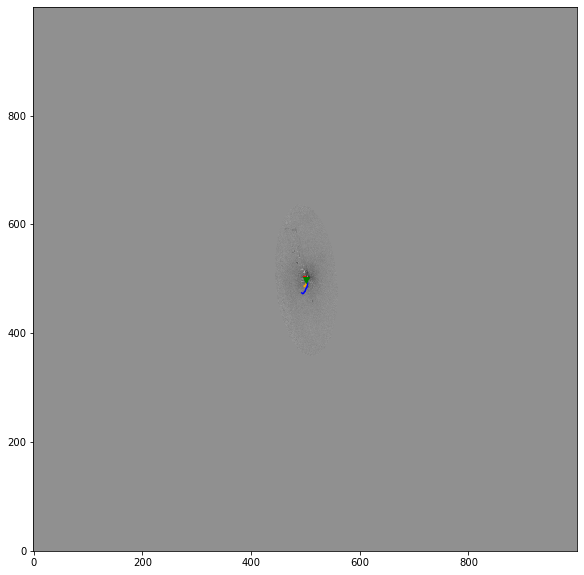

NGC3675


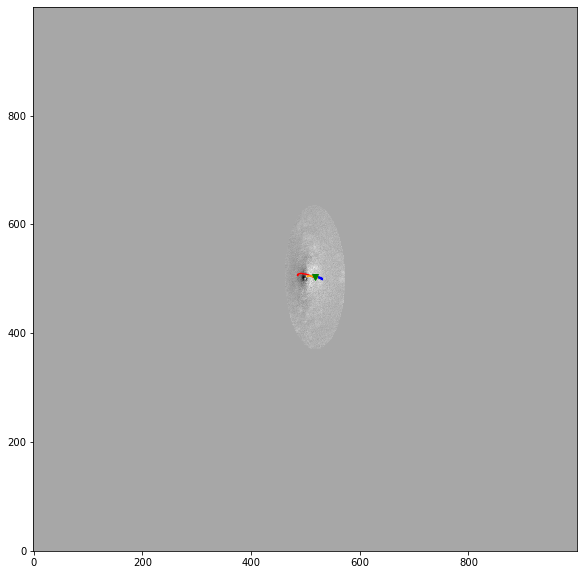

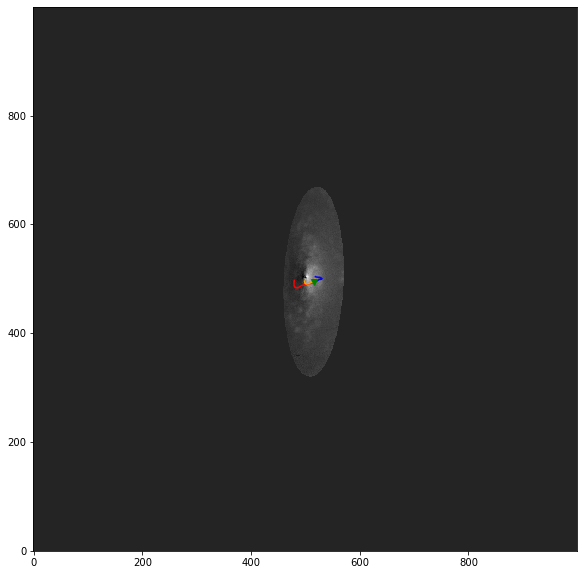

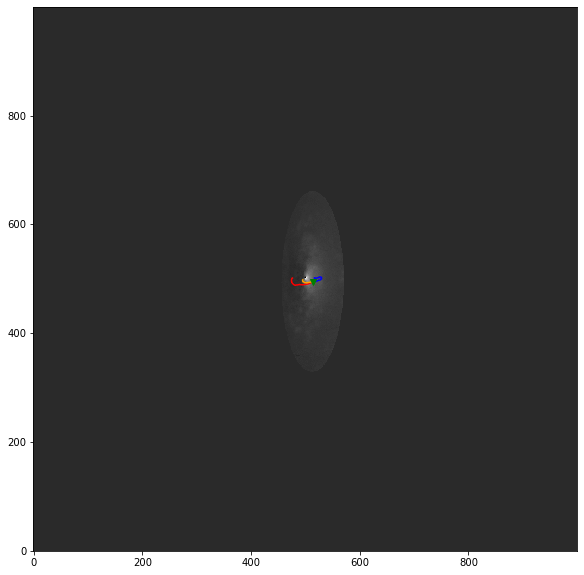

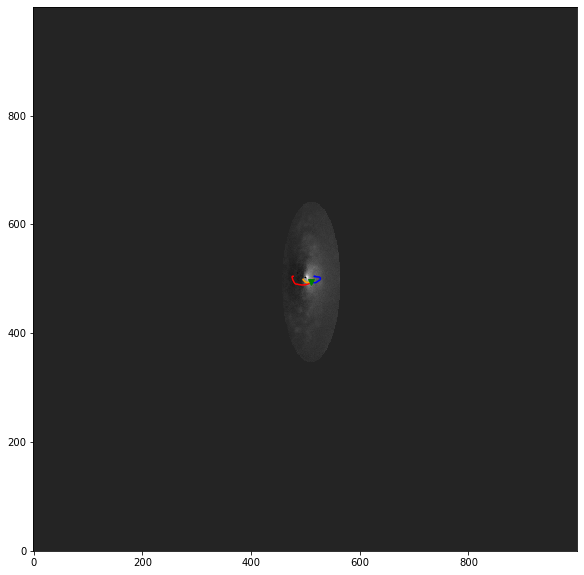

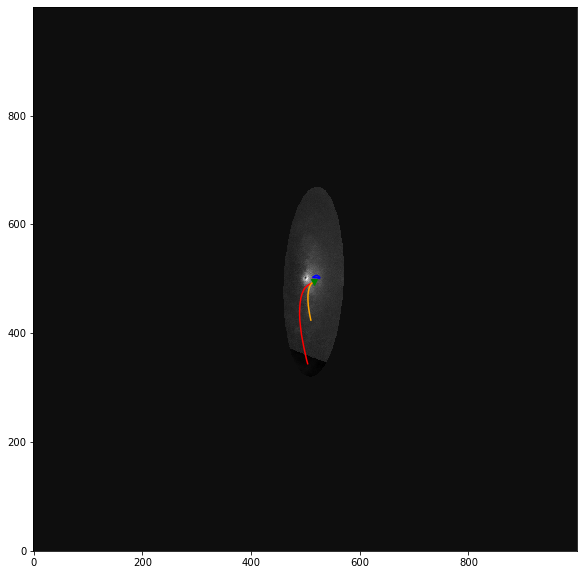

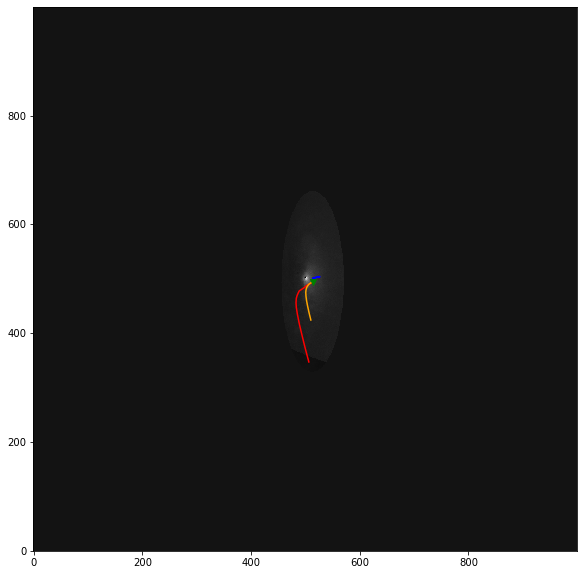

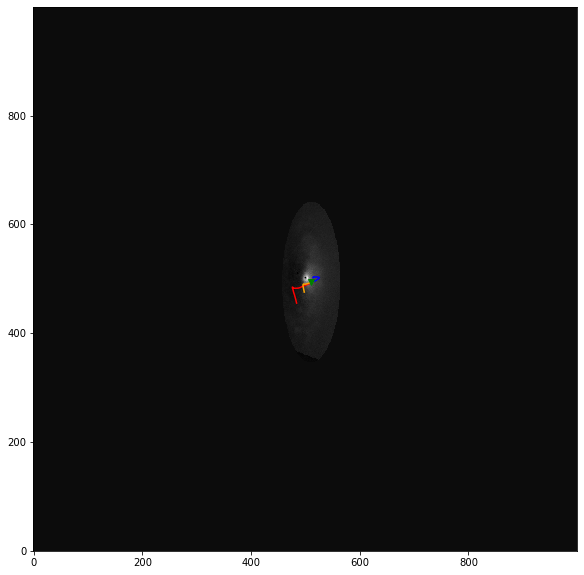

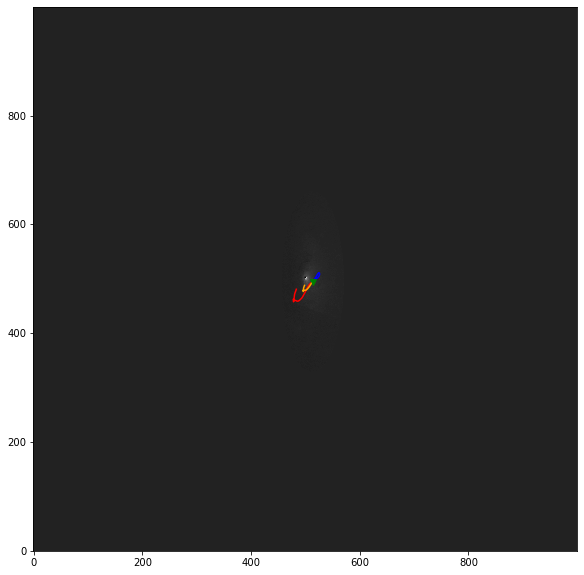

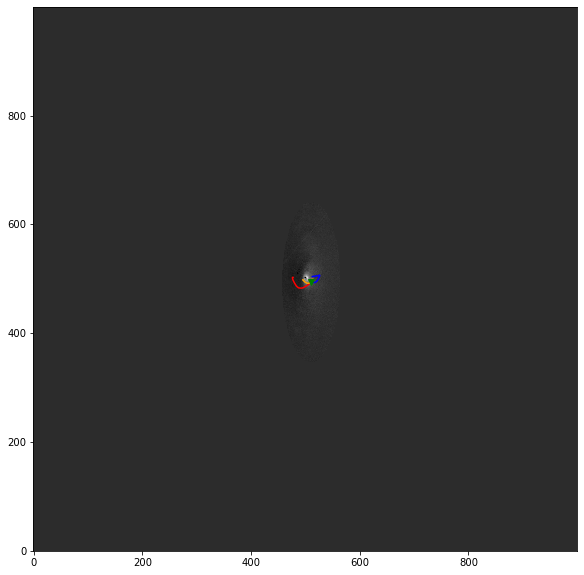

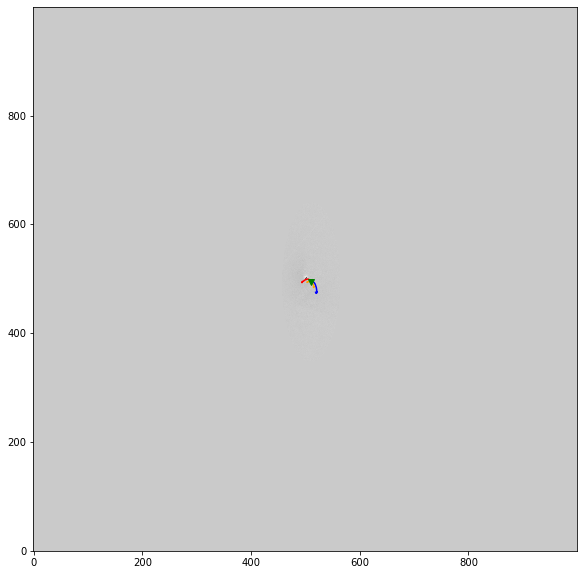

NGC3227


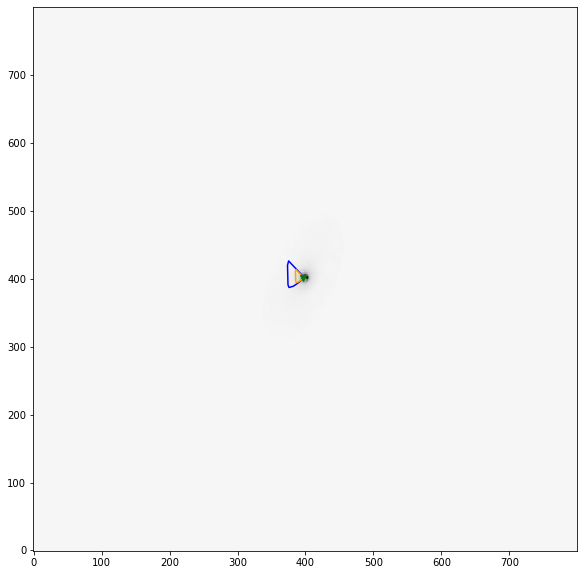

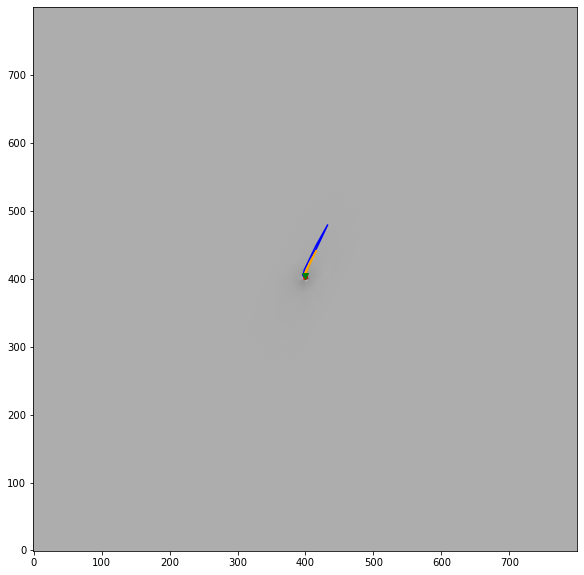

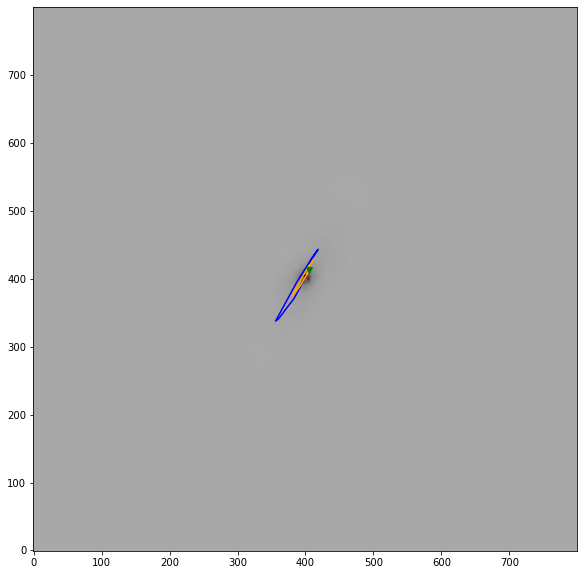

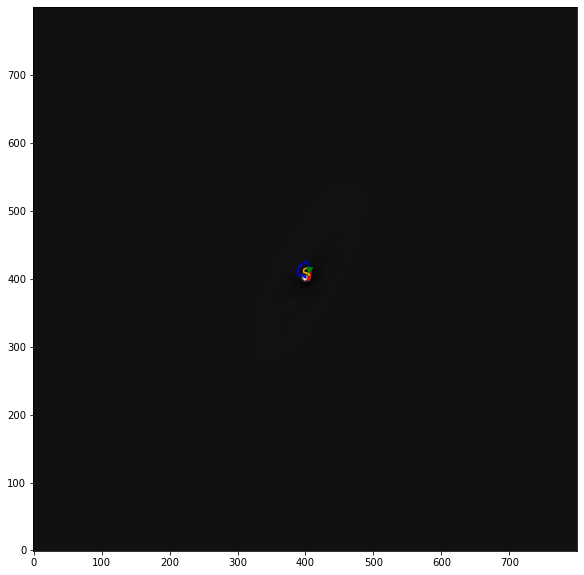

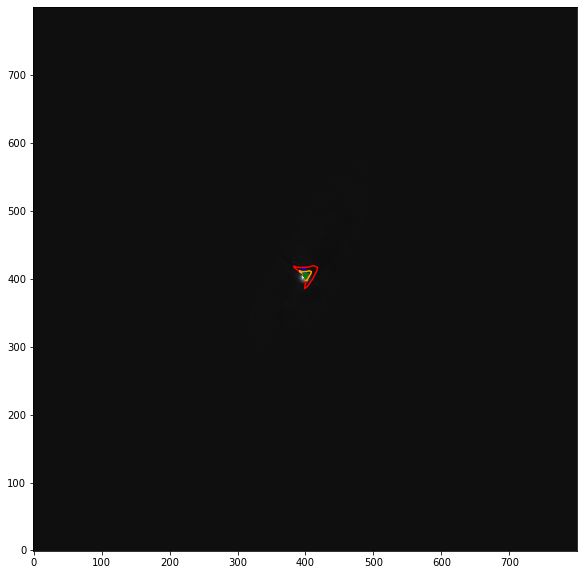

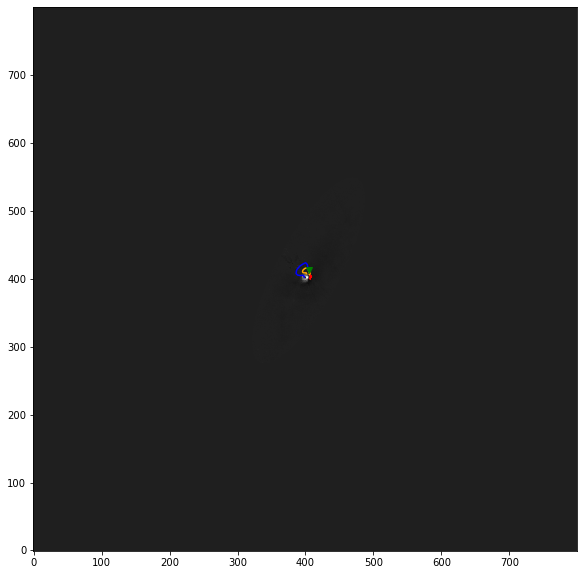

/Users/cora-at-work/opt/anaconda3/lib/python3.8/site-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


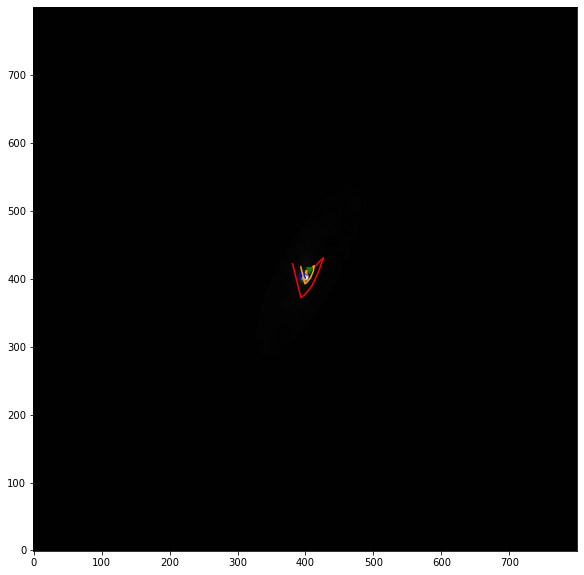

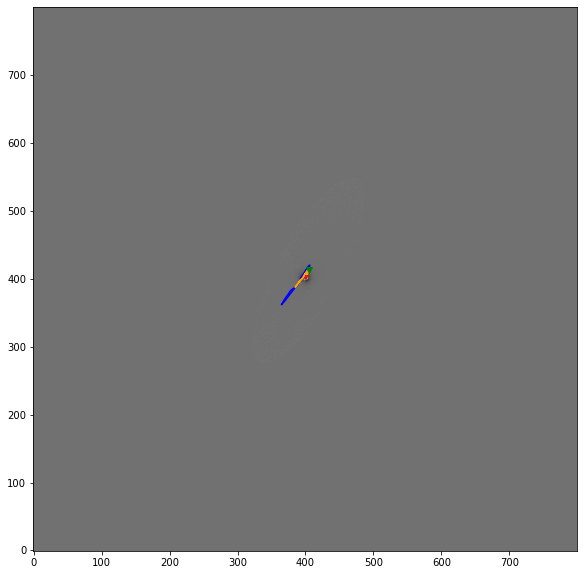

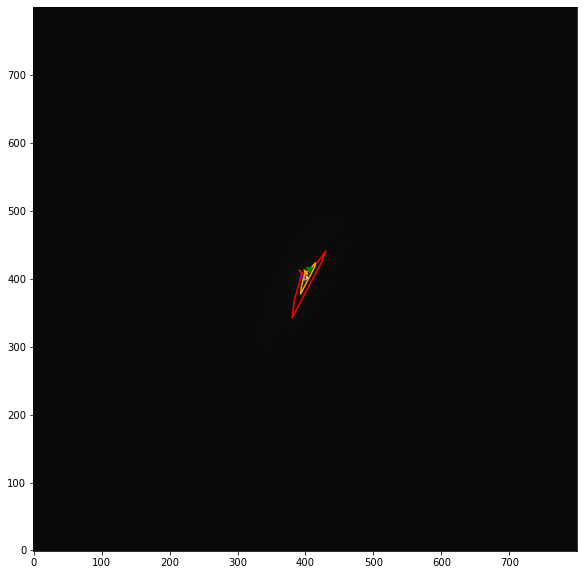

/Users/cora-at-work/opt/anaconda3/lib/python3.8/site-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


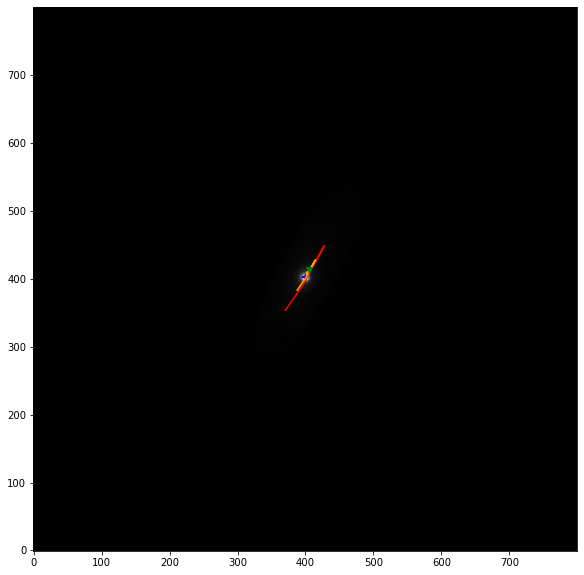

In [162]:
i = 1
import itertools
for name in get_galaxy_list():
    print(name)
    for (first_band,base_band) in itertools.combinations(bands_in_order, 2):
        diff = diff_sep(name,first_band,base_band)
    #path_d = "/Users/cora-at-work/Desktop/test_{}.fits".format(name)
    #write_fits(path_d,diff)
    #break
    i += 1
    if i > 10: break

In [163]:
#TODO:
# 1 - select two bands (first_band & base_band s.t. first_band comes before base_band in bands_in_order_list)
# 2 - pick a galaxy from table 2, read in fits file for first_band and base_band
# 3 - generate (foreground,background) using create_segmentation_mask
# 4 - use fits from #2 and foreground mask from #3 to create diff using create_diff_image
# 5 - Visualize using view_fits (experiment with mask:np.array and std_range:float)

In [8]:
#For example: For IC1683 table 2 (g,r) bands diff would look like: